In [1]:
from gym import spaces
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators

ts = TimeSeries(key='99S0ISLA0LGI3YNA', output_format='pandas')
goog_data, meta_data = ts.get_daily(symbol='GOOGL', outputsize='full')

In [2]:
from pandas import *
df = goog_data[1:732]
df2 = df.reset_index()
df2.head()

date  1. open  2. high   3. low  4. close  5. volume
0 2019-12-04  1306.10  1324.27  1303.05   1318.94  1761397.0
1 2019-12-03  1278.66  1297.23  1277.05   1294.74  1480026.0
2 2019-12-02  1302.56  1305.44  1280.38   1288.86  1328889.0
3 2019-11-29  1306.60  1309.95  1303.23   1304.09   640069.0
4 2019-11-27  1315.42  1317.64  1309.47   1312.13   940536.0

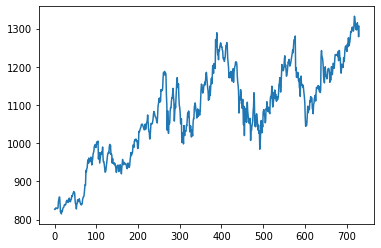

In [3]:
df_r = df.iloc[::-1]
goog_open = df_r["1. open"].values
plt.plot(range(0, len(goog_open)), goog_open)

In [4]:
fb_data, f_meta_data = ts.get_daily(symbol='FB', outputsize='full')

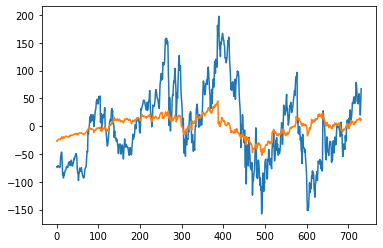

In [5]:
from scipy import signal

dfg = goog_data[:732]
dfg2 = df.reset_index()

dff = fb_data[:732]
dff2 = dff.reset_index()

dfg_r = dfg.iloc[::-1]
dfg_ri = dfg_r.reset_index()
goog_open = dfg_r["1. open"].values
goog_close = dfg_r["4. close"].values

goog_open = signal.detrend(goog_open)
goog_close = signal.detrend(goog_close)
plt.plot(range(0,len(goog_open)), goog_open)

dff_r = dff.iloc[::-1]
dff_ri = dff_r.reset_index()
fb_open = dff_r["1. open"].values
fb_close = dff_r["4. close"].values

fb_open = signal.detrend(fb_open)
fb_close = signal.detrend(fb_close)
plt.plot(range(0, len(fb_open)), fb_open)

In [6]:
print(goog_open.min())
print(goog_close.min())
print(fb_open.min())
print(fb_close.min())

-157.7493897029134
-157.8184294697768
-52.56180535413128
-51.64283442765631


In [7]:
goog_open += 158.
goog_close += 158.
fb_open += 158.
fb_close += 158.

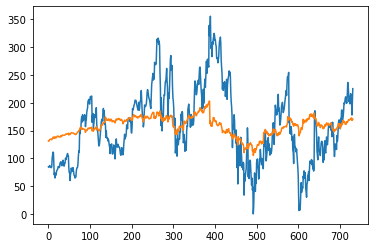

In [8]:
plt.plot(range(0, len(goog_open)), goog_open)
plt.plot(range(0, len(fb_open)), fb_open)

In [180]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 10000

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(6, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [181]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

env = DummyVecEnv([lambda: StockTradingEnv(dfg_ri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000)

obs = env.reset()
for i in range(2000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -0.000111 |
| fps                | 32        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.73e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000269 |
| fps                | 630       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 266       |
----------------------------------
---------------------------------
| explained_variance | -0.00156 |
| fps                | 698      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 0.976    |
---------------------------------
---------------------------------
| explained_variance | -0.00123 |
| fps                | 727      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1500     |
| value_loss         | 360      |
---------------------------------
----------------------------------
| explained_variance | -2.59e-05 |
| fps                | 748       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

KeyboardInterrupt: 

In [ ]:
import stable_baselines
print(stable_baselines.__version__)

In [19]:
from stable_baselines.common.evaluation import evaluate_policy

# Evaluate the agent
mean_reward, n_steps = evaluate_policy(model, StockTradingEnv(dfg_ri), n_eval_episodes=1)

KeyboardInterrupt: 

In [24]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".
                  format(best_mean_reward, mean_reward))
            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return False

In [25]:
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(dfg_ri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=25000, callback=callback)

# obs = env.reset()
# for i in range(2000):
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
#     env.render()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
my_key = '99S0ISLA0LGI3YNA'

from alpha_vantage.techindicators import TechIndicators
import matplotlib.pyplot as plt

ti = TechIndicators(key=my_key,output_format='pandas')
data, meta_data = ti.get_sma(symbol='GOOGL',interval='daily', time_period=60)


In [149]:
goog_sma = data

fb_sma, meta_data = ti.get_sma(symbol='AAPL',interval='daily', time_period=60)


In [150]:
fb_sma = db_sma

goog_ema, meta_data = ti.get_ema(symbol='GOOGL',interval='daily', time_period=60)
fb_ema, meta_data = ti.get_ema(symbol='AAPL',interval='daily', time_period=60)


In [151]:
goog_vwap, meta_data = ti.get_rsi(symbol='GOOGL',interval='daily', time_period=60)
fb_vwap, meta_data = ti.get_rsi(symbol='AAPL',interval='daily', time_period=60)


In [153]:
goog_rsi = goog_vwap
fb_rsi = fb_vwap

goog_cci, meta_data = ti.get_cci(symbol='GOOGL',interval='daily', time_period=60)
fb_cci, meta_data = ti.get_cci(symbol='AAPL',interval='daily', time_period=60)


In [252]:
df_g = goog_data[1:737]
df_gr = df_g.iloc[::-1]
df_gri = df_gr.reset_index()

df_f = fb_data[1:737]
df_fr = df_f.iloc[::-1]
df_fri = df_fr.reset_index()

df_g_sma = goog_sma[3056:3792]
df_gri_sma = df_g_sma.reset_index()

df_f_sma = fb_sma[3056:3792]
df_fri_sma = df_f_sma.reset_index()

df_g_ema = goog_ema[3056:3792]
df_gri_ema = df_g_ema.reset_index()

df_f_ema = fb_ema[3056:3792]
df_fri_ema = df_f_ema.reset_index()

df_g_rsi = goog_rsi[3055:3791]
df_gri_rsi = df_g_rsi.reset_index()

df_f_rsi = fb_rsi[3055:3791]
df_fri_rsi = df_f_rsi.reset_index()

df_g_cci = goog_cci[3056:3792]
df_gri_cci = df_g_cci.reset_index()

df_f_cci = fb_cci[3056:3792]
df_fri_cci = df_f_cci.reset_index()

In [265]:
df_g = goog_data[1:989]
df_gr = df_g.iloc[::-1]
df_gri = df_gr.reset_index()

df_f = fb_data[1:989]
df_fr = df_f.iloc[::-1]
df_fri = df_fr.reset_index()

df_g_sma = goog_sma[2804:3792]
df_gri_sma = df_g_sma.reset_index()

df_f_sma = fb_sma[2804:3792]
df_fri_sma = df_f_sma.reset_index()

df_g_ema = goog_ema[2804:3792]
df_gri_ema = df_g_ema.reset_index()

df_f_ema = fb_ema[2804:3792]
df_fri_ema = df_f_ema.reset_index()

df_g_rsi = goog_rsi[2803:3791]
df_gri_rsi = df_g_rsi.reset_index()

df_f_rsi = fb_rsi[2803:3791]
df_fri_rsi = df_f_rsi.reset_index()

df_g_cci = goog_cci[2804:3792]
df_gri_cci = df_g_cci.reset_index()

df_f_cci = fb_cci[2804:3792]
df_fri_cci = df_f_cci.reset_index()

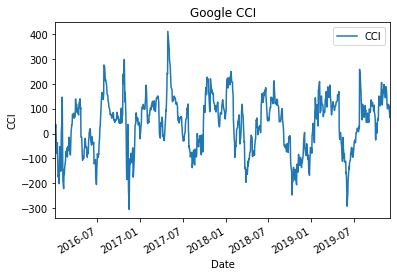

In [334]:
df_g_cci.plot()
plt.title('Google CCI')
plt.xlabel('Date')
plt.ylabel('CCI')
plt.show()

In [267]:
df_gri_cci.head()

date      CCI
0 2016-01-04  24.4456
1 2016-01-05  37.0363
2 2016-01-06  22.7639
3 2016-01-07 -21.4943
4 2016-01-08 -49.1454

In [268]:
print(df_g_sma.shape)
print(df_g_ema.shape)
print(df_g_rsi.shape)
print(df_g_cci.shape)

(988, 1)
(988, 1)
(988, 1)
(988, 1)


In [269]:
df_gri.shape

(988, 6)

In [270]:
df_gri.head()

date  1. open  2. high    3. low  4. close  5. volume
0 2016-01-04   762.20   762.20  747.5400    759.44  3369068.0
1 2016-01-05   764.10   769.20  755.6500    761.53  2260795.0
2 2016-01-06   750.37   765.73  748.0000    759.33  2410301.0
3 2016-01-07   746.49   755.31  735.2800    741.00  3156563.0
4 2016-01-08   747.80   750.12  728.9201    730.91  2375348.0

In [271]:
goog_sma.shape

(3793, 1)

In [272]:
df_g_sma.head()

SMA
date                
2016-01-04  746.9502
2016-01-05  748.5257
2016-01-06  749.9938
2016-01-07  751.0700
2016-01-08  751.8657

In [273]:
df_g_ema.head()

EMA
date                
2016-01-04  744.2262
2016-01-05  744.7935
2016-01-06  745.2701
2016-01-07  745.1301
2016-01-08  744.6639

In [274]:
df_g_cci.head()

CCI
date               
2016-01-04  24.4456
2016-01-05  37.0363
2016-01-06  22.7639
2016-01-07 -21.4943
2016-01-08 -49.1454

In [275]:
df_g_rsi.head()

RSI
date               
2016-01-04  55.5279
2016-01-05  55.7164
2016-01-06  55.4648
2016-01-07  53.4209
2016-01-08  52.3411

In [284]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv_EMA(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, df_ema):
        super(StockTradingEnv_EMA, self).__init__()
        self.df = df
        self.df_ema = df_ema
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(7, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,
                          self.df_ema.loc[self.current_step: self.current_step + 5, 'EMA'].values / MAX_SHARE_PRICE])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [285]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_EMA(df_gri, df_gri_ema)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 29       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 3.83e-05 |
| fps                | 505      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 541      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00159  |
| fps                | 596      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.16e-05 |
| fps                | 628       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
| total_t

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 723       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 2.37e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 723      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 5.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.27e-05 |
| fps                | 724      |
| nupdates           | 3300     |
| policy_entropy     | 2.64     |
| total_timesteps    | 16500    |
| value_loss         | 6.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 725      |
| nupdates           | 3400     |
| policy_entropy     | 2.62     |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 731      |
| nupdates           | 6100     |
| policy_entropy     | 2.4      |
| total_timesteps    | 30500    |
| value_loss         | 8.09e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00026 |
| fps                | 732      |
| nupdates           | 6200     |
| policy_entropy     | 2.41     |
| total_timesteps    | 31000    |
| value_loss         | 99.1     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 732       |
| nupdates           | 6300      |
| policy_entropy     | 2.42      |
| total_timesteps    | 31500     |
| value_loss         | 5.57e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000336 |
| fps                | 732      |
| nupdates           | 6400     |
| policy_entropy     | 2.4      |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 735       |
| nupdates           | 9100      |
| policy_entropy     | 2.15      |
| total_timesteps    | 45500     |
| value_loss         | 6.79e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 735       |
| nupdates           | 9200      |
| policy_entropy     | 2.13      |
| total_timesteps    | 46000     |
| value_loss         | 3.16e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 735       |
| nupdates           | 9300      |
| policy_entropy     | 2.12      |
| total_timesteps    | 46500     |
| value_loss         | 1.17e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 735      |
| nupdates           | 9400     |
| policy_entropy     | 2

Profit: 0.0
Step: 961
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 962
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 963
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 964
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 965
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 966
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.

Step: 102
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 103
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 104
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 105
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 106
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 107
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 108


Step: 229
Balance: 15069.688484070588
Shares held: 7 (Total sold: 2)
Avg cost for held shares: 722.9698530621888 (Total sales value: 1576.4171616302901)
Net worth: 20567.834436467827 (Max net worth: 20998.114975039243)
Profit: 567.8344364678269
Step: 230
Balance: 15069.688484070588
Shares held: 7 (Total sold: 2)
Avg cost for held shares: 722.9698530621888 (Total sales value: 1576.4171616302901)
Net worth: 20588.656287427606 (Max net worth: 20998.114975039243)
Profit: 588.656287427606
Step: 231
Balance: 15069.688484070588
Shares held: 7 (Total sold: 2)
Avg cost for held shares: 722.9698530621888 (Total sales value: 1576.4171616302901)
Net worth: 20534.40644597313 (Max net worth: 20998.114975039243)
Profit: 534.4064459731308
Step: 232
Balance: 15069.688484070588
Shares held: 7 (Total sold: 2)
Avg cost for held shares: 722.9698530621888 (Total sales value: 1576.4171616302901)
Net worth: 20516.939078953852 (Max net worth: 20998.114975039243)
Profit: 516.939078953852
Step: 233
Balance: 1506

Step: 351
Balance: 9327.34912787324
Shares held: 14 (Total sold: 7)
Avg cost for held shares: 808.0185464031646 (Total sales value: 5856.672810245424)
Net worth: 22984.671851515886 (Max net worth: 22984.671851515886)
Profit: 2984.6718515158864
Step: 352
Balance: 9327.34912787324
Shares held: 14 (Total sold: 7)
Avg cost for held shares: 808.0185464031646 (Total sales value: 5856.672810245424)
Net worth: 23162.978390478936 (Max net worth: 23162.978390478936)
Profit: 3162.9783904789365
Step: 353
Balance: 9327.34912787324
Shares held: 14 (Total sold: 7)
Avg cost for held shares: 808.0185464031646 (Total sales value: 5856.672810245424)
Net worth: 23223.9129737711 (Max net worth: 23223.9129737711)
Profit: 3223.912973771101
Step: 354
Balance: 9327.34912787324
Shares held: 14 (Total sold: 7)
Avg cost for held shares: 808.0185464031646 (Total sales value: 5856.672810245424)
Net worth: 23256.033510777892 (Max net worth: 23256.033510777892)
Profit: 3256.033510777892
Step: 355
Balance: 9327.349127

Step: 443
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 22945.262738885627 (Max net worth: 23386.77755699776)
Profit: 2945.262738885627
Step: 444
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 23086.6596538788 (Max net worth: 23386.77755699776)
Profit: 3086.6596538788
Step: 445
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 23250.9605217884 (Max net worth: 23386.77755699776)
Profit: 3250.960521788398
Step: 446
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 23271.186429716356 (Max net worth: 23386.77755699776)
Profit: 3271.1864297163556
Step: 447
Balance: 8371.52311

Step: 531
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 23994.77910890557 (Max net worth: 26184.685497352977)
Profit: 3994.779108905572
Step: 532
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24215.664954403466 (Max net worth: 26184.685497352977)
Profit: 4215.664954403466
Step: 533
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24142.71412428206 (Max net worth: 26184.685497352977)
Profit: 4142.714124282062
Step: 534
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24455.07963205577 (Max net worth: 26184.685497352977)
Profit: 4455.079632055771
Step: 535
Balance: 8371

Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 25977.50917304883 (Max net worth: 26184.685497352977)
Profit: 5977.509173048831
Step: 621
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 26123.333171534712 (Max net worth: 26184.685497352977)
Profit: 6123.333171534712
Step: 622
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 25926.530274907218 (Max net worth: 26184.685497352977)
Profit: 5926.530274907218
Step: 623
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 25935.23655526785 (Max net worth: 26184.685497352977)
Profit: 5935.236555267849
Step: 624
Balance: 8371.52311844

Step: 735
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24861.566877370224 (Max net worth: 27636.72103090522)
Profit: 4861.566877370224
Step: 736
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 25281.16465276803 (Max net worth: 27636.72103090522)
Profit: 5281.164652768031
Step: 737
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24886.8958919728 (Max net worth: 27636.72103090522)
Profit: 4886.895891972799
Step: 738
Balance: 8371.523118447349
Shares held: 15 (Total sold: 10)
Avg cost for held shares: 843.5070279677965 (Total sales value: 8717.766190098862)
Net worth: 24095.490534500423 (Max net worth: 27636.72103090522)
Profit: 4095.4905345004227
Step: 739
Balance: 8371.52

In [282]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv_RSI(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, df_rsi):
        super(StockTradingEnv_RSI, self).__init__()
        self.df = df
        self.df_rsi = df_rsi
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(7, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,
                          self.df_rsi.loc[self.current_step: self.current_step + 5, 'RSI'].values / MAX_SHARE_PRICE])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [283]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_RSI(df_gri, df_gri_rsi)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 28       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 3.37e-05 |
| fps                | 508      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 567      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00164  |
| fps                | 621      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 653       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
| total_t

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 761       |
| nupdates           | 3100      |
| policy_entropy     | 2.64      |
| total_timesteps    | 15500     |
| value_loss         | 2.57e+05  |
----------------------------------
---------------------------------
| explained_variance | 7.93e-06 |
| fps                | 761      |
| nupdates           | 3200     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16000    |
| value_loss         | 3.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 761      |
| nupdates           | 3300     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16500    |
| value_loss         | 9.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 761      |
| nupdates           | 3400     |
| policy_entropy     | 2.61     |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 744       |
| nupdates           | 6100      |
| policy_entropy     | 2.36      |
| total_timesteps    | 30500     |
| value_loss         | 3.04e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.00021 |
| fps                | 744      |
| nupdates           | 6200     |
| policy_entropy     | 2.36     |
| total_timesteps    | 31000    |
| value_loss         | 208      |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 744       |
| nupdates           | 6300      |
| policy_entropy     | 2.37      |
| total_timesteps    | 31500     |
| value_loss         | 1.05e+04  |
----------------------------------
----------------------------------
| explained_variance | -0.000149 |
| fps                | 744       |
| nupdates           | 6400      |
| policy_entropy     | 2.36 

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 744       |
| nupdates           | 9100      |
| policy_entropy     | 2.08      |
| total_timesteps    | 45500     |
| value_loss         | 1.93e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 744       |
| nupdates           | 9200      |
| policy_entropy     | 2.07      |
| total_timesteps    | 46000     |
| value_loss         | 6.73e+04  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 744       |
| nupdates           | 9300      |
| policy_entropy     | 2.06      |
| total_timesteps    | 46500     |
| value_loss         | 1.77e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 744      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 950
Balance: 17907.42094090964
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 1046.2895295451801 (Total sales value: 0.0)
Net worth: 20309.112094751446 (Max net worth: 20392.01173993097)
Profit: 309.1120947514464
Step: 951
Balance: 17907.42094090964
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 1046.2895295451801 (Total sales value: 0.0)
Net worth: 20347.555678481207 (Max net worth: 20392.01173993097)
Profit: 347.555678481207
Step: 952
Balance: 17907.42094090964
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 1046.2895295451801 (Total sales value: 0.0)
Net worth: 20339.702898353535 (Max net worth: 20392.01173993097)
Profit: 339.7028983535347
Step: 953
Balance: 17907.42094090964
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 1046.2895295451801 (Total sales value: 0.0)
Net worth: 20382.026368268598 (Max net worth: 20392.01173993097)
Profit: 382.02636826859816
Step: 954
Balance: 17907.42094090964
Shares held: 2 (Total sold: 0)
Avg cost for hel

Step: 85
Balance: 19348.58010396639
Shares held: 0 (Total sold: 3)
Avg cost for held shares: 0 (Total sales value: 2209.182066519336)
Net worth: 19348.58010396639 (Max net worth: 20552.426970630622)
Profit: -651.4198960336107
Step: 86
Balance: 19348.58010396639
Shares held: 0 (Total sold: 3)
Avg cost for held shares: 0 (Total sales value: 2209.182066519336)
Net worth: 19348.58010396639 (Max net worth: 20552.426970630622)
Profit: -651.4198960336107
Step: 87
Balance: 19348.58010396639
Shares held: 0 (Total sold: 3)
Avg cost for held shares: 0 (Total sales value: 2209.182066519336)
Net worth: 19348.58010396639 (Max net worth: 20552.426970630622)
Profit: -651.4198960336107
Step: 88
Balance: 19348.58010396639
Shares held: 0 (Total sold: 3)
Avg cost for held shares: 0 (Total sales value: 2209.182066519336)
Net worth: 19348.58010396639 (Max net worth: 20552.426970630622)
Profit: -651.4198960336107
Step: 89
Balance: 19348.58010396639
Shares held: 0 (Total sold: 3)
Avg cost for held shares: 0 (

Step: 177
Balance: 10625.300534725948
Shares held: 13 (Total sold: 12)
Avg cost for held shares: 722.5100779314859 (Total sales value: 9381.12421177158)
Net worth: 20863.4614959161 (Max net worth: 21247.253928373568)
Profit: 863.4614959161008
Step: 178
Balance: 10625.300534725948
Shares held: 13 (Total sold: 12)
Avg cost for held shares: 722.5100779314859 (Total sales value: 9381.12421177158)
Net worth: 20996.787218747948 (Max net worth: 21247.253928373568)
Profit: 996.7872187479479
Step: 179
Balance: 10625.300534725948
Shares held: 13 (Total sold: 12)
Avg cost for held shares: 722.5100779314859 (Total sales value: 9381.12421177158)
Net worth: 21005.09474904913 (Max net worth: 21247.253928373568)
Profit: 1005.0947490491308
Step: 180
Balance: 10625.300534725948
Shares held: 13 (Total sold: 12)
Avg cost for held shares: 722.5100779314859 (Total sales value: 9381.12421177158)
Net worth: 20979.460784790565 (Max net worth: 21247.253928373568)
Profit: 979.4607847905645
Step: 181
Balance: 106

Step: 292
Balance: 940.6414073780848
Shares held: 25 (Total sold: 12)
Avg cost for held shares: 763.0916056182872 (Total sales value: 9381.12421177158)
Net worth: 22324.981435240785 (Max net worth: 22367.184812627114)
Profit: 2324.981435240785
Step: 293
Balance: 940.6414073780848
Shares held: 25 (Total sold: 12)
Avg cost for held shares: 763.0916056182872 (Total sales value: 9381.12421177158)
Net worth: 22239.97165237791 (Max net worth: 22367.184812627114)
Profit: 2239.97165237791
Step: 294
Balance: 940.6414073780848
Shares held: 25 (Total sold: 12)
Avg cost for held shares: 763.0916056182872 (Total sales value: 9381.12421177158)
Net worth: 22166.311901549052 (Max net worth: 22367.184812627114)
Profit: 2166.311901549052
Step: 295
Balance: 940.6414073780848
Shares held: 25 (Total sold: 12)
Avg cost for held shares: 763.0916056182872 (Total sales value: 9381.12421177158)
Net worth: 22120.892548620533 (Max net worth: 22367.184812627114)
Profit: 2120.8925486205335
Step: 296
Balance: 940.64

Step: 409
Balance: 3119.8107708857033
Shares held: 22 (Total sold: 24)
Avg cost for held shares: 815.3046247213816 (Total sales value: 19576.804446111862)
Net worth: 23865.96102929444 (Max net worth: 24994.116025260162)
Profit: 3865.9610292944417
Step: 410
Balance: 3119.8107708857033
Shares held: 22 (Total sold: 24)
Avg cost for held shares: 815.3046247213816 (Total sales value: 19576.804446111862)
Net worth: 23774.393417822666 (Max net worth: 24994.116025260162)
Profit: 3774.3934178226664
Step: 411
Balance: 3119.8107708857033
Shares held: 22 (Total sold: 24)
Avg cost for held shares: 815.3046247213816 (Total sales value: 19576.804446111862)
Net worth: 23507.964917000387 (Max net worth: 24994.116025260162)
Profit: 3507.964917000387
Step: 412
Balance: 3119.8107708857033
Shares held: 22 (Total sold: 24)
Avg cost for held shares: 815.3046247213816 (Total sales value: 19576.804446111862)
Net worth: 23449.322673123545 (Max net worth: 24994.116025260162)
Profit: 3449.3226731235445
Step: 413


Step: 527
Balance: 5194.445393790402
Shares held: 20 (Total sold: 28)
Avg cost for held shares: 828.4944952961639 (Total sales value: 23572.22547110454)
Net worth: 26826.422199391964 (Max net worth: 28945.328565664575)
Profit: 6826.422199391964
Step: 528
Balance: 5194.445393790402
Shares held: 20 (Total sold: 28)
Avg cost for held shares: 828.4944952961639 (Total sales value: 23572.22547110454)
Net worth: 26272.397860882214 (Max net worth: 28945.328565664575)
Profit: 6272.397860882214
Step: 529
Balance: 5194.445393790402
Shares held: 20 (Total sold: 28)
Avg cost for held shares: 828.4944952961639 (Total sales value: 23572.22547110454)
Net worth: 26891.029063706315 (Max net worth: 28945.328565664575)
Profit: 6891.029063706315
Step: 530
Balance: 5194.445393790402
Shares held: 20 (Total sold: 28)
Avg cost for held shares: 828.4944952961639 (Total sales value: 23572.22547110454)
Net worth: 25378.75937818209 (Max net worth: 28945.328565664575)
Profit: 5378.759378182091
Step: 531
Balance: 51

Step: 645
Balance: 3985.2640791213553
Shares held: 21 (Total sold: 28)
Avg cost for held shares: 846.622439075825 (Total sales value: 23572.22547110454)
Net worth: 30538.131222800872 (Max net worth: 30538.131222800872)
Profit: 10538.131222800872
Step: 646
Balance: 3985.2640791213553
Shares held: 21 (Total sold: 28)
Avg cost for held shares: 846.622439075825 (Total sales value: 23572.22547110454)
Net worth: 30916.350705928347 (Max net worth: 30916.350705928347)
Profit: 10916.350705928347
Step: 647
Balance: 3985.2640791213553
Shares held: 21 (Total sold: 28)
Avg cost for held shares: 846.622439075825 (Total sales value: 23572.22547110454)
Net worth: 30956.541156562373 (Max net worth: 30956.541156562373)
Profit: 10956.541156562373
Step: 648
Balance: 3985.2640791213553
Shares held: 21 (Total sold: 28)
Avg cost for held shares: 846.622439075825 (Total sales value: 23572.22547110454)
Net worth: 29823.983869920397 (Max net worth: 30956.541156562373)
Profit: 9823.983869920397
Step: 649
Balance

Step: 766
Balance: 14978.626585069938
Shares held: 11 (Total sold: 38)
Avg cost for held shares: 846.6224390758251 (Total sales value: 34565.58797705312)
Net worth: 27020.361358177666 (Max net worth: 30956.541156562373)
Profit: 7020.361358177666
Step: 767
Balance: 14978.626585069938
Shares held: 11 (Total sold: 38)
Avg cost for held shares: 846.6224390758251 (Total sales value: 34565.58797705312)
Net worth: 27161.56083153782 (Max net worth: 30956.541156562373)
Profit: 7161.5608315378195
Step: 768
Balance: 14978.626585069938
Shares held: 11 (Total sold: 38)
Avg cost for held shares: 846.6224390758251 (Total sales value: 34565.58797705312)
Net worth: 26911.446504337568 (Max net worth: 30956.541156562373)
Profit: 6911.446504337568
Step: 769
Balance: 14978.626585069938
Shares held: 11 (Total sold: 38)
Avg cost for held shares: 846.6224390758251 (Total sales value: 34565.58797705312)
Net worth: 26914.725936051684 (Max net worth: 30956.541156562373)
Profit: 6914.725936051684
Step: 770
Balanc

In [280]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv_CCI(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, df_cci):
        super(StockTradingEnv_CCI, self).__init__()
        self.df = df
        self.df_cci = df_cci
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(7, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,
                          self.df_cci.loc[self.current_step: self.current_step + 5, 'CCI'].values / MAX_SHARE_PRICE])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [281]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_CCI(df_gri, df_gri_cci)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 30        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.92e+06  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000128 |
| fps                | 547       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 1.47e+03  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 558      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00217  |
| fps                | 545      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.42e-05 |
| fps                | 531       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 641       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 2.59e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.28e-05 |
| fps                | 636      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 1.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 635      |
| nupdates           | 3300     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16500    |
| value_loss         | 1.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 638      |
| nupdates           | 3400     |
| policy_entropy     | 2.63     |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 649       |
| nupdates           | 6100      |
| policy_entropy     | 2.42      |
| total_timesteps    | 30500     |
| value_loss         | 6.94e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.0037  |
| fps                | 648      |
| nupdates           | 6200     |
| policy_entropy     | 2.43     |
| total_timesteps    | 31000    |
| value_loss         | 0.894    |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 647       |
| nupdates           | 6300      |
| policy_entropy     | 2.43      |
| total_timesteps    | 31500     |
| value_loss         | 6.63e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.000313 |
| fps                | 647      |
| nupdates           | 6400     |
| policy_entropy     | 2.42     

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 652       |
| nupdates           | 9100      |
| policy_entropy     | 2.16      |
| total_timesteps    | 45500     |
| value_loss         | 6.21e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 651       |
| nupdates           | 9200      |
| policy_entropy     | 2.15      |
| total_timesteps    | 46000     |
| value_loss         | 1.52e+04  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 652       |
| nupdates           | 9300      |
| policy_entropy     | 2.14      |
| total_timesteps    | 46500     |
| value_loss         | 9.01e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 653      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 945
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 946
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 947
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 948
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 949
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 950
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 951


Step: 86
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 87
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 88
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 89
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 90
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 91
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 92
Balance

Step: 210
Balance: 10921.526362976063
Shares held: 13 (Total sold: 6)
Avg cost for held shares: 729.4614947644966 (Total sales value: 4781.294763501496)
Net worth: 21508.480758614387 (Max net worth: 21821.963300001025)
Profit: 1508.480758614387
Step: 211
Balance: 10921.526362976063
Shares held: 13 (Total sold: 6)
Avg cost for held shares: 729.4614947644966 (Total sales value: 4781.294763501496)
Net worth: 21424.814633487083 (Max net worth: 21821.963300001025)
Profit: 1424.8146334870835
Step: 212
Balance: 10921.526362976063
Shares held: 13 (Total sold: 6)
Avg cost for held shares: 729.4614947644966 (Total sales value: 4781.294763501496)
Net worth: 21172.018840128378 (Max net worth: 21821.963300001025)
Profit: 1172.0188401283776
Step: 213
Balance: 10921.526362976063
Shares held: 13 (Total sold: 6)
Avg cost for held shares: 729.4614947644966 (Total sales value: 4781.294763501496)
Net worth: 21093.76100007048 (Max net worth: 21821.963300001025)
Profit: 1093.7610000704808
Step: 214
Balance:

Step: 335
Balance: 6096.2861389660875
Shares held: 19 (Total sold: 21)
Avg cost for held shares: 820.7816446272064 (Total sales value: 17392.51242331794)
Net worth: 23855.245714966542 (Max net worth: 23855.245714966542)
Profit: 3855.2457149665424
Step: 336
Balance: 6096.2861389660875
Shares held: 19 (Total sold: 21)
Avg cost for held shares: 820.7816446272064 (Total sales value: 17392.51242331794)
Net worth: 23959.8461066576 (Max net worth: 23959.8461066576)
Profit: 3959.8461066575983
Step: 337
Balance: 6096.2861389660875
Shares held: 19 (Total sold: 21)
Avg cost for held shares: 820.7816446272064 (Total sales value: 17392.51242331794)
Net worth: 24229.993918699623 (Max net worth: 24229.993918699623)
Profit: 4229.9939186996235
Step: 338
Balance: 6096.2861389660875
Shares held: 19 (Total sold: 21)
Avg cost for held shares: 820.7816446272064 (Total sales value: 17392.51242331794)
Net worth: 24212.66975596149 (Max net worth: 24229.993918699623)
Profit: 4212.669755961491
Step: 339
Balance:

Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 25210.861812004783 (Max net worth: 25573.185494798545)
Profit: 5210.861812004783
Step: 460
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26053.37879545251 (Max net worth: 26053.37879545251)
Profit: 6053.3787954525105
Step: 461
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26041.58135919886 (Max net worth: 26053.37879545251)
Profit: 6041.581359198859
Step: 462
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26045.385461706384 (Max net worth: 26053.37879545251)
Profit: 6045.385461706384
Step: 463
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held sh

Step: 583
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26224.66112079632 (Max net worth: 29599.577805101562)
Profit: 6224.6611207963215
Step: 584
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26110.31469748306 (Max net worth: 29599.577805101562)
Profit: 6110.31469748306
Step: 585
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 25857.106952076247 (Max net worth: 29599.577805101562)
Profit: 5857.106952076247
Step: 586
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26163.814731787374 (Max net worth: 29599.577805101562)
Profit: 6163.814731787374
Step: 587
Balance:

Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 27485.471884893763 (Max net worth: 31826.03228988167)
Profit: 7485.471884893763
Step: 710
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 27496.084472427236 (Max net worth: 31826.03228988167)
Profit: 7496.084472427236
Step: 711
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26508.186878319837 (Max net worth: 31826.03228988167)
Profit: 6508.186878319837
Step: 712
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held shares: 843.6989230189887 (Total sales value: 17392.51242331794)
Net worth: 26639.428389001463 (Max net worth: 31826.03228988167)
Profit: 6639.428389001463
Step: 713
Balance: 2286.0621574462684
Shares held: 23 (Total sold: 21)
Avg cost for held sh

Step: 838
Balance: 14396.392444612555
Shares held: 12 (Total sold: 32)
Avg cost for held shares: 843.6989230189887 (Total sales value: 29502.842710484227)
Net worth: 28441.891747999594 (Max net worth: 31826.03228988167)
Profit: 8441.891747999594
Step: 839
Balance: 14396.392444612555
Shares held: 12 (Total sold: 32)
Avg cost for held shares: 843.6989230189887 (Total sales value: 29502.842710484227)
Net worth: 28582.832530849744 (Max net worth: 31826.03228988167)
Profit: 8582.832530849744
Step: 840
Balance: 14396.392444612555
Shares held: 12 (Total sold: 32)
Avg cost for held shares: 843.6989230189887 (Total sales value: 29502.842710484227)
Net worth: 28621.069501039874 (Max net worth: 31826.03228988167)
Profit: 8621.069501039874
Step: 841
Balance: 14396.392444612555
Shares held: 12 (Total sold: 32)
Avg cost for held shares: 843.6989230189887 (Total sales value: 29502.842710484227)
Net worth: 28580.582688304145 (Max net worth: 31826.03228988167)
Profit: 8580.582688304145
Step: 842
Balanc

In [276]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(6, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [277]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(df_gri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 31        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.92e+06  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -3.16e-05 |
| fps                | 585       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 1.54e+03  |
----------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 679       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00172  |
| fps                | 712      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 85.3     |
---------------------------------
----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 737       |
| nupdates           | 400       |
| policy_entropy     | 2.82 

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 767       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 3.43e+05  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-06 |
| fps                | 766      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 4.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.11e-05 |
| fps                | 766      |
| nupdates           | 3300     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16500    |
| value_loss         | 3.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 766      |
| nupdates           | 3400     |
| policy_entropy     | 2.63     |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 737      |
| nupdates           | 6100     |
| policy_entropy     | 2.39     |
| total_timesteps    | 30500    |
| value_loss         | 1.04e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000494 |
| fps                | 738       |
| nupdates           | 6200      |
| policy_entropy     | 2.4       |
| total_timesteps    | 31000     |
| value_loss         | 36.6      |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 738       |
| nupdates           | 6300      |
| policy_entropy     | 2.41      |
| total_timesteps    | 31500     |
| value_loss         | 2.46e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000519 |
| fps                | 739      |
| nupdates           | 6400     |
| policy_entropy     | 2.38     

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 735       |
| nupdates           | 9100      |
| policy_entropy     | 2.12      |
| total_timesteps    | 45500     |
| value_loss         | 7.78e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 735       |
| nupdates           | 9200      |
| policy_entropy     | 2.11      |
| total_timesteps    | 46000     |
| value_loss         | 8.17e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 735       |
| nupdates           | 9300      |
| policy_entropy     | 2.09      |
| total_timesteps    | 46500     |
| value_loss         | 4.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 736      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 929
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 930
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 931
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 932
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 933
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 934
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 935


Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 30
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 31
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 32
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 33
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 34
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 35
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000

Step: 128
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20023.606588670977 (Max net worth: 20027.28589540466)
Profit: 23.606588670976635
Step: 129
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20025.75800163856 (Max net worth: 20027.28589540466)
Profit: 25.7580016385582
Step: 130
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20032.38916873237 (Max net worth: 20032.38916873237)
Profit: 32.38916873237031
Step: 131
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20042.988104138414 (Max net worth: 20042.988104138414)
Profit: 42.9881041384142
Step: 132
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shar

Step: 209
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20142.496914719984 (Max net worth: 20156.85006078045)
Profit: 142.4969147199845
Step: 210
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20132.736019135325 (Max net worth: 20156.85006078045)
Profit: 132.73601913532548
Step: 211
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20126.3001633563 (Max net worth: 20156.85006078045)
Profit: 126.30016335629989
Step: 212
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held shares: 681.6450882214714 (Total sales value: 0.0)
Net worth: 20106.854333097937 (Max net worth: 20156.85006078045)
Profit: 106.85433309793734
Step: 213
Balance: 19318.35491177853
Shares held: 1 (Total sold: 0)
Avg cost for held s

Step: 291
Balance: 18509.433775005436
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 745.2831124972831 (Total sales value: 0.0)
Net worth: 20201.50502736093 (Max net worth: 20223.55724742536)
Profit: 201.5050273609304
Step: 292
Balance: 18509.433775005436
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 745.2831124972831 (Total sales value: 0.0)
Net worth: 20220.180977234453 (Max net worth: 20223.55724742536)
Profit: 220.18097723445317
Step: 293
Balance: 18509.433775005436
Shares held: 2 (Total sold: 0)
Avg cost for held shares: 745.2831124972831 (Total sales value: 0.0)
Net worth: 20213.380194605423 (Max net worth: 20223.55724742536)
Profit: 213.38019460542273
Step: 294
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 20207.487414539115 (Max net worth: 20223.55724742536)
Profit: 207.48741453911498
Step: 295
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for 

Step: 409
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 20771.3674755041 (Max net worth: 21138.79582270573)
Profit: 771.3674755040993
Step: 410
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 20746.394490557253 (Max net worth: 21138.79582270573)
Profit: 746.3944905572534
Step: 411
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 20673.732172151176 (Max net worth: 21138.79582270573)
Profit: 673.7321721511762
Step: 412
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 20657.738832912037 (Max net worth: 21138.79582270573)
Profit: 657.7388329120367
Step: 413
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held

Step: 485
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21266.592544351897 (Max net worth: 21538.10224613468)
Profit: 1266.5925443518972
Step: 486
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21198.014969308162 (Max net worth: 21538.10224613468)
Profit: 1198.014969308162
Step: 487
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21273.753612217704 (Max net worth: 21538.10224613468)
Profit: 1273.7536122177044
Step: 488
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21347.019388217937 (Max net worth: 21538.10224613468)
Profit: 1347.0193882179374
Step: 489
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for

Profit: 1563.9089708514657
Step: 607
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21666.458897966968 (Max net worth: 22238.59144750033)
Profit: 1666.458897966968
Step: 608
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21901.17699471605 (Max net worth: 22238.59144750033)
Profit: 1901.17699471605
Step: 609
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22016.495941495956 (Max net worth: 22238.59144750033)
Profit: 2016.4959414959558
Step: 610
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22022.196101284586 (Max net worth: 22238.59144750033)
Profit: 2022.196101284586
Step: 611
Balance: 15113.326495938081
Shares held: 6 (Tota

Step: 688
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22223.67094453185 (Max net worth: 22819.405660921228)
Profit: 2223.6709445318484
Step: 689
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22276.42820305658 (Max net worth: 22819.405660921228)
Profit: 2276.428203056581
Step: 690
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22324.092352071344 (Max net worth: 22819.405660921228)
Profit: 2324.092352071344
Step: 691
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22351.735387222674 (Max net worth: 22819.405660921228)
Profit: 2351.735387222674
Step: 692
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for

Step: 793
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21830.162920386985 (Max net worth: 22819.405660921228)
Profit: 1830.1629203869852
Step: 794
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21830.63773521374 (Max net worth: 22819.405660921228)
Profit: 1830.6377352137388
Step: 795
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 21922.631273017767 (Max net worth: 22819.405660921228)
Profit: 1922.631273017767
Step: 796
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost for held shares: 814.4455840103201 (Total sales value: 0.0)
Net worth: 22039.402348939246 (Max net worth: 22819.405660921228)
Profit: 2039.4023489392457
Step: 797
Balance: 15113.326495938081
Shares held: 6 (Total sold: 0)
Avg cost 

In [ ]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(df_fri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

In [286]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv_All(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, df_cci, df_ema, df_rsi):
        super(StockTradingEnv_All, self).__init__()
        self.df = df
        self.df_cci = df_cci
        self.df_ema = df_ema
        self.df_rsi = df_rsi
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(9, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,
                          self.df_cci.loc[self.current_step: self.current_step + 5, 'CCI'].values / MAX_SHARE_PRICE,
                          self.df_ema.loc[self.current_step: self.current_step + 5, 'EMA'].values / MAX_SHARE_PRICE,
                          self.df_rsi.loc[self.current_step: self.current_step + 5, 'RSI'].values / MAX_SHARE_PRICE])
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [288]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_All(df_gri, df_gri_cci, df_gri_ema, df_gri_rsi)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpLnLstmPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 0.000263 |
| fps                | 7        |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 6.23e+05 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000459 |
| fps                | 258       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 137       |
----------------------------------
---------------------------------
| explained_variance | 7.34e-05 |
| fps                | 319      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 794      |
---------------------------------
----------------------------------
| explained_variance | -0.000886 |
| fps                | 346       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1500      |
| value_loss         | 186       |
----------------------------------
---------------------------------
| explained_variance | 3.99e-06 |
| fps                | 354      |
| nupdates           | 400      |
| policy_entropy     | 2.83     

---------------------------------
| explained_variance | 0.00266  |
| fps                | 403      |
| nupdates           | 3100     |
| policy_entropy     | 2.4      |
| total_timesteps    | 15500    |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.000776 |
| fps                | 404      |
| nupdates           | 3200     |
| policy_entropy     | 2.39     |
| total_timesteps    | 16000    |
| value_loss         | 7.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000929 |
| fps                | 405      |
| nupdates           | 3300     |
| policy_entropy     | 2.39     |
| total_timesteps    | 16500    |
| value_loss         | 1.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000394 |
| fps                | 405      |
| nupdates           | 3400     |
| policy_entropy     | 2.37     |
| total_timest

---------------------------------
| explained_variance | 0.000233 |
| fps                | 410      |
| nupdates           | 6200     |
| policy_entropy     | 1.89     |
| total_timesteps    | 31000    |
| value_loss         | 1.12e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 410      |
| nupdates           | 6300     |
| policy_entropy     | 1.89     |
| total_timesteps    | 31500    |
| value_loss         | 4.01e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.07e-05 |
| fps                | 411       |
| nupdates           | 6400      |
| policy_entropy     | 1.88      |
| total_timesteps    | 32000     |
| value_loss         | 1.51e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 411      |
| nupdates           | 6500     |
| policy_entropy     | 1.87     |
| tota

---------------------------------
| explained_variance | 2.78e-05 |
| fps                | 409      |
| nupdates           | 9200     |
| policy_entropy     | 1.45     |
| total_timesteps    | 46000    |
| value_loss         | 1.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 409      |
| nupdates           | 9300     |
| policy_entropy     | 1.42     |
| total_timesteps    | 46500    |
| value_loss         | 1.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000738 |
| fps                | 409       |
| nupdates           | 9400      |
| policy_entropy     | 1.41      |
| total_timesteps    | 47000     |
| value_loss         | 2.06e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 409       |
| nupdates           | 9500      |
| policy_entropy     | 1.38      |
|

Step: 928
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 929
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 930
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 931
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 932
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 933
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 934


Step: 48
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 49
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 50
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 51
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 52
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 53
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 54
Balance

Step: 150
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 151
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 152
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 153
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 154
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 155
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 156


Step: 251
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 252
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 253
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 254
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 255
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 256
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 257


Step: 354
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 355
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 356
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 357
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 358
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 359
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 360


Step: 457
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 458
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 459
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 460
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 461
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 462
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 463


Step: 557
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 558
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 559
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 560
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 561
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

Step: 659
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 660
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 661
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 662
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 663
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

Step: 759
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 760
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 761
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 762
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 763
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

In [292]:

from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_CCI(df_gri, df_gri_cci)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpLnLstmPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000404 |
| fps                | 7         |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.37e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.00271  |
| fps                | 276      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 39.2     |
---------------------------------
---------------------------------
| explained_variance | 0.000192 |
| fps                | 342      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 1.09e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.00258 |
| fps                | 370      |
| nupdates           | 300      |
| policy_entropy     | 2.83     |
| tota

---------------------------------
| explained_variance | 0.000711 |
| fps                | 437      |
| nupdates           | 3100     |
| policy_entropy     | 2.4      |
| total_timesteps    | 15500    |
| value_loss         | 2.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000222 |
| fps                | 438      |
| nupdates           | 3200     |
| policy_entropy     | 2.4      |
| total_timesteps    | 16000    |
| value_loss         | 1.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0.000241 |
| fps                | 438      |
| nupdates           | 3300     |
| policy_entropy     | 2.4      |
| total_timesteps    | 16500    |
| value_loss         | 2.32e+06 |
---------------------------------
---------------------------------
| explained_variance | 9.96e-05 |
| fps                | 438      |
| nupdates           | 3400     |
| policy_entropy     | 2.38     |
| total_timest

---------------------------------
| explained_variance | 6e-05    |
| fps                | 443      |
| nupdates           | 6200     |
| policy_entropy     | 1.89     |
| total_timesteps    | 31000    |
| value_loss         | 2.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 443      |
| nupdates           | 6300     |
| policy_entropy     | 1.89     |
| total_timesteps    | 31500    |
| value_loss         | 6.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.06e-05 |
| fps                | 443      |
| nupdates           | 6400     |
| policy_entropy     | 1.86     |
| total_timesteps    | 32000    |
| value_loss         | 3.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 443      |
| nupdates           | 6500     |
| policy_entropy     | 1.86     |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 442       |
| nupdates           | 9300      |
| policy_entropy     | 1.38      |
| total_timesteps    | 46500     |
| value_loss         | 7.36e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 442      |
| nupdates           | 9400     |
| policy_entropy     | 1.37     |
| total_timesteps    | 47000    |
| value_loss         | 1.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 442      |
| nupdates           | 9500     |
| policy_entropy     | 1.33     |
| total_timesteps    | 47500    |
| value_loss         | 7.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 442      |
| nupdates           | 9600     |
| policy_entropy     | 1.31     |
| tota

Step: 936
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 937
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 938
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 939
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 940
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 941
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 942


Step: 60
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 61
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 62
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 63
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 64
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 65
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 66
Balance

Step: 170
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 171
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 172
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 173
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 174
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held share

Step: 282
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 283
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 284
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 285
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held shares: 0 (Total sales value: 19877.681198183414)
Net worth: 20020.44082121925 (Max net worth: 20020.44082121925)
Profit: 20.44082121925021
Step: 286
Balance: 20020.44082121925
Shares held: 0 (Total sold: 27)
Avg cost for held share

Step: 392
Balance: 20157.005244530905
Shares held: 0 (Total sold: 50)
Avg cost for held shares: 0 (Total sales value: 39473.06502358326)
Net worth: 20157.005244530905 (Max net worth: 20235.214244764753)
Profit: 157.00524453090475
Step: 393
Balance: 20157.005244530905
Shares held: 0 (Total sold: 50)
Avg cost for held shares: 0 (Total sales value: 39473.06502358326)
Net worth: 20157.005244530905 (Max net worth: 20235.214244764753)
Profit: 157.00524453090475
Step: 394
Balance: 20157.005244530905
Shares held: 0 (Total sold: 50)
Avg cost for held shares: 0 (Total sales value: 39473.06502358326)
Net worth: 20157.005244530905 (Max net worth: 20235.214244764753)
Profit: 157.00524453090475
Step: 395
Balance: 20157.005244530905
Shares held: 0 (Total sold: 50)
Avg cost for held shares: 0 (Total sales value: 39473.06502358326)
Net worth: 20157.005244530905 (Max net worth: 20235.214244764753)
Profit: 157.00524453090475
Step: 396
Balance: 20157.005244530905
Shares held: 0 (Total sold: 50)
Avg cost f

Step: 503
Balance: 20504.35201248488
Shares held: 0 (Total sold: 70)
Avg cost for held shares: 0 (Total sales value: 59440.59383877917)
Net worth: 20504.35201248488 (Max net worth: 20504.35201248488)
Profit: 504.3520124848801
Step: 504
Balance: 20504.35201248488
Shares held: 0 (Total sold: 70)
Avg cost for held shares: 0 (Total sales value: 59440.59383877917)
Net worth: 20504.35201248488 (Max net worth: 20504.35201248488)
Profit: 504.3520124848801
Step: 505
Balance: 20504.35201248488
Shares held: 0 (Total sold: 70)
Avg cost for held shares: 0 (Total sales value: 59440.59383877917)
Net worth: 20504.35201248488 (Max net worth: 20504.35201248488)
Profit: 504.3520124848801
Step: 506
Balance: 20504.35201248488
Shares held: 0 (Total sold: 70)
Avg cost for held shares: 0 (Total sales value: 59440.59383877917)
Net worth: 20504.35201248488 (Max net worth: 20504.35201248488)
Profit: 504.3520124848801
Step: 507
Balance: 20504.35201248488
Shares held: 0 (Total sold: 70)
Avg cost for held shares: 0

Step: 613
Balance: 21605.74483860743
Shares held: 0 (Total sold: 88)
Avg cost for held shares: 0 (Total sales value: 80111.92307502351)
Net worth: 21605.74483860743 (Max net worth: 21913.519717682317)
Profit: 1605.7448386074284
Step: 614
Balance: 21605.74483860743
Shares held: 0 (Total sold: 88)
Avg cost for held shares: 0 (Total sales value: 80111.92307502351)
Net worth: 21605.74483860743 (Max net worth: 21913.519717682317)
Profit: 1605.7448386074284
Step: 615
Balance: 21605.74483860743
Shares held: 0 (Total sold: 88)
Avg cost for held shares: 0 (Total sales value: 80111.92307502351)
Net worth: 21605.74483860743 (Max net worth: 21913.519717682317)
Profit: 1605.7448386074284
Step: 616
Balance: 21605.74483860743
Shares held: 0 (Total sold: 88)
Avg cost for held shares: 0 (Total sales value: 80111.92307502351)
Net worth: 21605.74483860743 (Max net worth: 21913.519717682317)
Profit: 1605.7448386074284
Step: 617
Balance: 21605.74483860743
Shares held: 0 (Total sold: 88)
Avg cost for held s

Step: 724
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 725
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 726
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 727
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 728
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg c

Step: 834
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 835
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 836
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 837
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg cost for held shares: 0 (Total sales value: 100503.78224633788)
Net worth: 21527.242808803545 (Max net worth: 21913.519717682317)
Profit: 1527.242808803545
Step: 838
Balance: 21527.242808803545
Shares held: 0 (Total sold: 105)
Avg c

In [293]:
from stable_baselines.common.policies import MlpLnLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(df_gri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpLnLstmPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | -6.2e-05 |
| fps                | 7        |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 9.79e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000281 |
| fps                | 289       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 5.84      |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 354      |
| nupdates           | 200      |
| policy_entropy     | 2.84     |
| total_timesteps    | 1000     |
| value_loss         | 1.3e+03  |
---------------------------------
----------------------------------
| explained_variance | -0.000834 |
| fps                | 383       |
| nupdates           | 300       |
| policy_entropy     | 2.83      |
|

---------------------------------
| explained_variance | 0.000299 |
| fps                | 452      |
| nupdates           | 3000     |
| policy_entropy     | 2.44     |
| total_timesteps    | 15000    |
| value_loss         | 7.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00088  |
| fps                | 453      |
| nupdates           | 3100     |
| policy_entropy     | 2.42     |
| total_timesteps    | 15500    |
| value_loss         | 1.34e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000236 |
| fps                | 454      |
| nupdates           | 3200     |
| policy_entropy     | 2.41     |
| total_timesteps    | 16000    |
| value_loss         | 7.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.000306 |
| fps                | 454      |
| nupdates           | 3300     |
| policy_entropy     | 2.42     |
| total_timest

---------------------------------
| explained_variance | 0.000138 |
| fps                | 444      |
| nupdates           | 6100     |
| policy_entropy     | 1.92     |
| total_timesteps    | 30500    |
| value_loss         | 3.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 444      |
| nupdates           | 6200     |
| policy_entropy     | 1.9      |
| total_timesteps    | 31000    |
| value_loss         | 1.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 444      |
| nupdates           | 6300     |
| policy_entropy     | 1.9      |
| total_timesteps    | 31500    |
| value_loss         | 4.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.35e-05 |
| fps                | 444      |
| nupdates           | 6400     |
| policy_entropy     | 1.87     |
| total_timest

---------------------------------
| explained_variance | 0.000115 |
| fps                | 449      |
| nupdates           | 9200     |
| policy_entropy     | 1.44     |
| total_timesteps    | 46000    |
| value_loss         | 2.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 449      |
| nupdates           | 9300     |
| policy_entropy     | 1.41     |
| total_timesteps    | 46500    |
| value_loss         | 2.27e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 449      |
| nupdates           | 9400     |
| policy_entropy     | 1.4      |
| total_timesteps    | 47000    |
| value_loss         | 3.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 450      |
| nupdates           | 9500     |
| policy_entropy     | 1.36     |
| total_timest

Step: 952
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 953
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 954
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 955
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 956
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 957
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 958


Step: 93
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 94
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 95
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 96
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 97
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 98
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 99
Balance

Step: 216
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 217
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 218
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 219
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 220
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 221
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 222


Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 339
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 340
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 341
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 342
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 343
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 344
Balance: 2

Step: 462
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 463
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 464
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 465
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 466
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 467
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 468


Step: 586
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 587
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 588
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 589
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 590
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

Step: 703
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 704
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 705
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 706
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 707
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

Step: 824
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 825
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 826
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 827
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost for held shares: 0 (Total sales value: 20710.12486495396)
Net worth: 21140.188454832158 (Max net worth: 21409.167705197437)
Profit: 1140.1884548321577
Step: 828
Balance: 21140.188454832158
Shares held: 0 (Total sold: 18)
Avg cost f

In [297]:
goog_sar, meta_data = ti.get_sar(symbol='GOOGL',interval='daily')
fb_sar, meta_data = ti.get_sar(symbol='AAPL',interval='daily')



In [315]:
df_f_sar = fb_sar[4043:5031]
df_fri_sar = df_f_sar.reset_index()

In [316]:
df_fri_sar.head()

date       SAR
0 2016-01-04  112.7989
1 2016-01-05  111.9350
2 2016-01-06  111.1402
3 2016-01-07  110.1259
4 2016-01-08  108.7563

In [318]:
df_fri_sar.shape

(988, 2)

In [325]:
df_g_sar = goog_sar[2862:3850]
df_gri_sar = df_g_sar.reset_index()

In [326]:
df_gri_sar.head()

date       SAR
0 2016-01-04  740.3696
1 2016-01-05  741.5360
2 2016-01-06  742.6790
3 2016-01-07  798.6900
4 2016-01-08  798.0559

In [328]:
df_gri_sar.shape

(988, 2)

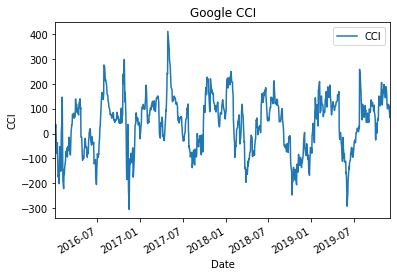

In [335]:
df_g_cci.plot()
plt.title('Google CCI')
plt.xlabel('Date')
plt.ylabel('CCI')
plt.show()

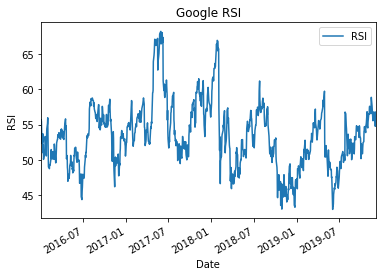

In [336]:
df_g_rsi.plot()
plt.title('Google RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

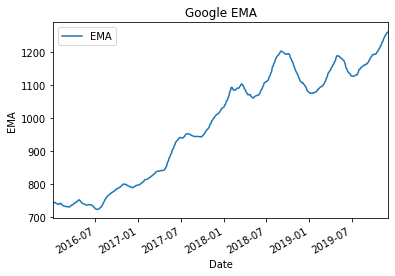

In [337]:
df_g_ema.plot()
plt.title('Google EMA')
plt.xlabel('Date')
plt.ylabel('EMA')
plt.show()

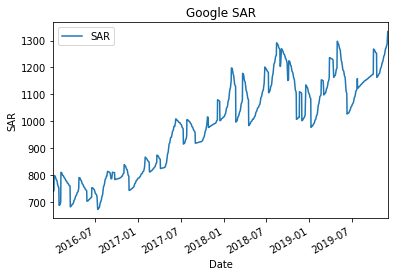

In [339]:
df_g_sar.plot()
plt.title('Google SAR')
plt.xlabel('Date')
plt.ylabel('SAR')
plt.show()

In [344]:
import random
import pandas as pd
import json
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from gym.utils import seeding

from stable_baselines.common import set_global_seeds
set_global_seeds(40)

MAX_ACCOUNT_BALANCE = 2147483647
MAX_NUM_SHARES = 2147483647
MAX_SHARE_PRICE = 5000
MAX_OPEN_POSITIONS = 5
MAX_STEPS = 20000

INITIAL_ACCOUNT_BALANCE = 20000

class StockTradingEnv_SAR(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, df_sar):
        super(StockTradingEnv_SAR, self).__init__()
        self.df = df
        self.df_sar = df_sar
        self.reward_range = (0, MAX_ACCOUNT_BALANCE) 
        
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        
        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(low=0, high=1, shape=(7, 6), dtype=np.float16)
        
    def reset(self):
        # Reset the state of the environment to an initial state
        self.balance = INITIAL_ACCOUNT_BALANCE
        self.net_worth = INITIAL_ACCOUNT_BALANCE
        self.max_net_worth = INITIAL_ACCOUNT_BALANCE
        self.shares_held = 0
        self.cost_basis = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Set the current step to a random point within the data frame
        self.current_step = random.randint(0, len(self.df.loc[:, '1. open'].values) - 6)
        return self._next_observation()

    def _next_observation(self):
        # Get the data points for the last 5 days and scale to between 0-1
        frame = np.array([self.df.loc[self.current_step: self.current_step + 5, '1. open'].values / MAX_SHARE_PRICE, 
                          self.df.loc[self.current_step: self.current_step + 5, '2. high'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '3. low'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '4. close'].values / MAX_SHARE_PRICE,
                          self.df.loc[self.current_step: self.current_step + 5, '5. volume'].values / MAX_NUM_SHARES,
                          self.df_sar.loc[self.current_step: self.current_step + 5, 'SAR'].values / MAX_SHARE_PRICE])
        
        # Append additional data and scale each value to between 0-1
        obs = np.append(frame, [[self.balance / MAX_ACCOUNT_BALANCE,
                                 self.max_net_worth / MAX_ACCOUNT_BALANCE,
                                 self.shares_held / MAX_NUM_SHARES,
                                 self.cost_basis / MAX_SHARE_PRICE,
                                 self.total_shares_sold / MAX_NUM_SHARES,
                                 self.total_sales_value / (MAX_NUM_SHARES * MAX_SHARE_PRICE),]], axis=0)
        return obs
    
    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)
        self.current_step += 1
        if self.current_step > len(self.df.loc[:, '1. open'].values) - 6:
            self.current_step = 0
        
        delay_modifier = (self.current_step / MAX_STEPS)
  
        reward = self.balance * delay_modifier
        done = self.net_worth <= 0
        obs = self._next_observation()
        return obs, reward, done, {}
    
    def _take_action(self, action):
        # Set the current price to a random price within the time step
        current_price = random.uniform(self.df.loc[self.current_step, "1. open"], self.df.loc[self.current_step, "4. close"])

        action_type = action[0]
        amount = action[1]

        if action_type < 1:
            # Buy amount % of balance in shares
            total_possible = int(self.balance / current_price)
            shares_bought = int(total_possible * amount)
            prev_cost = self.cost_basis * self.shares_held
            additional_cost = shares_bought * current_price

            self.balance -= additional_cost
            self.cost_basis = (prev_cost + additional_cost) / (self.shares_held + shares_bought)
            self.shares_held += shares_bought

        elif action_type < 2:
            # Sell amount % of shares held
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * current_price
            self.shares_held -= shares_sold
            self.total_shares_sold += shares_sold
            self.total_sales_value += shares_sold * current_price

        self.net_worth = self.balance + self.shares_held * current_price

        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        if self.shares_held == 0:
            self.cost_basis = 0

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(
            f'Shares held: {self.shares_held} (Total sold: {self.total_shares_sold})')
        print(
            f'Avg cost for held shares: {self.cost_basis} (Total sales value: {self.total_sales_value})')
        print(
            f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth})')
        print(f'Profit: {profit}')

In [358]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_SAR(df_gri, df_gri_sar)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 30       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 0.000149 |
| fps                | 575      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 663       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.15e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00161  |
| fps                | 695      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.41e-05 |
| fps                | 715       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

KeyboardInterrupt: 

In [359]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_SAR(df_fri, df_fri_sar)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 32        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 5.61e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | -0.00039 |
| fps                | 611      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 590      |
---------------------------------
----------------------------------
| explained_variance | -0.000654 |
| fps                | 679       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 109       |
----------------------------------
---------------------------------
| explained_variance | 0.00599  |
| fps                | 708      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 3.69     |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 723       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 774      |
| nupdates           | 3100     |
| policy_entropy     | 2.68     |
| total_timesteps    | 15500    |
| value_loss         | 2.19e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 774       |
| nupdates           | 3200      |
| policy_entropy     | 2.65      |
| total_timesteps    | 16000     |
| value_loss         | 1.61e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 774       |
| nupdates           | 3300      |
| policy_entropy     | 2.64      |
| total_timesteps    | 16500     |
| value_loss         | 1.27e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 775       |
| nupdates           | 3400      |
| policy_entropy     | 2.63 

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 780      |
| nupdates           | 6100     |
| policy_entropy     | 2.43     |
| total_timesteps    | 30500    |
| value_loss         | 4.7e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.24e-05 |
| fps                | 780       |
| nupdates           | 6200      |
| policy_entropy     | 2.42      |
| total_timesteps    | 31000     |
| value_loss         | 70        |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 780      |
| nupdates           | 6300     |
| policy_entropy     | 2.4      |
| total_timesteps    | 31500    |
| value_loss         | 5.2e+05  |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 780       |
| nupdates           | 6400      |
| policy_entropy     | 2.39      |
|

---------------------------------
| explained_variance | 0        |
| fps                | 777      |
| nupdates           | 9100     |
| policy_entropy     | 2.04     |
| total_timesteps    | 45500    |
| value_loss         | 1.26e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 777       |
| nupdates           | 9200      |
| policy_entropy     | 2.02      |
| total_timesteps    | 46000     |
| value_loss         | 1.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 777      |
| nupdates           | 9300     |
| policy_entropy     | 2.02     |
| total_timesteps    | 46500    |
| value_loss         | 1.32e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 777       |
| nupdates           | 9400      |
| policy_entropy     | 2         |
|

Step: 124
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 125
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 126
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 127
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 128
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 129
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 130


Step: 248
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 249
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 250
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 251
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 252
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 253
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 254


Step: 375
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 376
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 377
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 378
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 379
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 380
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 381


Step: 489
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 490
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 491
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 492
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 493
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 494
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 495


Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 605
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 606
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 607
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 608
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 609
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 610
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost f

Step: 720
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 721
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 722
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 723
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 724
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 725
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 726


Step: 833
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 834
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 835
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 836
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 837
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 838
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 839


Profit: 0.0
Step: 947
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 948
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 949
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 950
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 951
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.0
Step: 952
Balance: 20000.0
Shares held: 0 (Total sold: 0)
Avg cost for held shares: 0 (Total sales value: 0.0)
Net worth: 20000.0 (Max net worth: 20000)
Profit: 0.

In [357]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_EMA(df_fri, df_fri_ema)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 32        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 5.61e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000391 |
| fps                | 597       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 590       |
----------------------------------
----------------------------------
| explained_variance | -0.000628 |
| fps                | 672       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 111       |
----------------------------------
----------------------------------
| explained_variance | -0.000124 |
| fps                | 704       |
| nupdates           | 300       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1500      |
| value_loss         | 3.35      |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 680       |
| nupdates           | 400       |
| policy_entropy    

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 741       |
| nupdates           | 3100      |
| policy_entropy     | 2.73      |
| total_timesteps    | 15500     |
| value_loss         | 1.63e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 742       |
| nupdates           | 3200      |
| policy_entropy     | 2.69      |
| total_timesteps    | 16000     |
| value_loss         | 5.8e+06   |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 742       |
| nupdates           | 3300      |
| policy_entropy     | 2.69      |
| total_timesteps    | 16500     |
| value_loss         | 3.19e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 743       |
| nupdates           | 3400      |
| policy_entropy    

---------------------------------
| explained_variance | 0        |
| fps                | 758      |
| nupdates           | 6100     |
| policy_entropy     | 2.47     |
| total_timesteps    | 30500    |
| value_loss         | 2.4e+06  |
---------------------------------
----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 757       |
| nupdates           | 6200      |
| policy_entropy     | 2.46      |
| total_timesteps    | 31000     |
| value_loss         | 800       |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 757      |
| nupdates           | 6300     |
| policy_entropy     | 2.45     |
| total_timesteps    | 31500    |
| value_loss         | 2.57e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 757       |
| nupdates           | 6400      |
| policy_entropy     | 2.44      |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 751      |
| nupdates           | 9100     |
| policy_entropy     | 2.08     |
| total_timesteps    | 45500    |
| value_loss         | 1.57e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 751       |
| nupdates           | 9200      |
| policy_entropy     | 2.07      |
| total_timesteps    | 46000     |
| value_loss         | 2.36e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 752      |
| nupdates           | 9300     |
| policy_entropy     | 2.07     |
| total_timesteps    | 46500    |
| value_loss         | 2.01e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 752       |
| nupdates           | 9400      |
| policy_entropy     | 2.05      |
|

Step: 125
Balance: 8832.816170280756
Shares held: 101 (Total sold: 28)
Avg cost for held shares: 112.04583130485115 (Total sales value: 3084.4584755069864)
Net worth: 20389.88802660739 (Max net worth: 20907.213274914007)
Profit: 389.8880266073902
Step: 126
Balance: 8832.816170280756
Shares held: 101 (Total sold: 28)
Avg cost for held shares: 112.04583130485115 (Total sales value: 3084.4584755069864)
Net worth: 20366.854838518717 (Max net worth: 20907.213274914007)
Profit: 366.85483851871686
Step: 127
Balance: 8832.816170280756
Shares held: 101 (Total sold: 28)
Avg cost for held shares: 112.04583130485115 (Total sales value: 3084.4584755069864)
Net worth: 20346.204079852065 (Max net worth: 20907.213274914007)
Profit: 346.20407985206475
Step: 128
Balance: 8832.816170280756
Shares held: 101 (Total sold: 28)
Avg cost for held shares: 112.04583130485115 (Total sales value: 3084.4584755069864)
Net worth: 20282.220352034077 (Max net worth: 20907.213274914007)
Profit: 282.2203520340772
Step: 1

Step: 252
Balance: 7424.9680290724955
Shares held: 112 (Total sold: 28)
Avg cost for held shares: 113.6114027053413 (Total sales value: 3084.4584755069864)
Net worth: 20320.876303936406 (Max net worth: 22351.89625585737)
Profit: 320.87630393640575
Step: 253
Balance: 7424.9680290724955
Shares held: 112 (Total sold: 28)
Avg cost for held shares: 113.6114027053413 (Total sales value: 3084.4584755069864)
Net worth: 20463.8701938324 (Max net worth: 22351.89625585737)
Profit: 463.8701938324011
Step: 254
Balance: 7424.9680290724955
Shares held: 112 (Total sold: 28)
Avg cost for held shares: 113.6114027053413 (Total sales value: 3084.4584755069864)
Net worth: 20595.416209934527 (Max net worth: 22351.89625585737)
Profit: 595.4162099345267
Step: 255
Balance: 7064.592132095831
Shares held: 115 (Total sold: 28)
Avg cost for held shares: 113.78133043456425 (Total sales value: 3084.4584755069864)
Net worth: 20879.001516201286 (Max net worth: 22351.89625585737)
Profit: 879.001516201286
Step: 256
Bala

Step: 376
Balance: 7670.838817712338
Shares held: 111 (Total sold: 35)
Avg cost for held shares: 114.88133661770917 (Total sales value: 4154.149838756271)
Net worth: 24438.45380816632 (Max net worth: 24818.29189012513)
Profit: 4438.4538081663195
Step: 377
Balance: 7670.838817712338
Shares held: 111 (Total sold: 35)
Avg cost for held shares: 114.88133661770917 (Total sales value: 4154.149838756271)
Net worth: 24435.160457615926 (Max net worth: 24818.29189012513)
Profit: 4435.160457615926
Step: 378
Balance: 7670.838817712338
Shares held: 111 (Total sold: 35)
Avg cost for held shares: 114.88133661770917 (Total sales value: 4154.149838756271)
Net worth: 24450.09915540947 (Max net worth: 24818.29189012513)
Profit: 4450.099155409469
Step: 379
Balance: 7670.838817712338
Shares held: 111 (Total sold: 35)
Avg cost for held shares: 114.88133661770917 (Total sales value: 4154.149838756271)
Net worth: 24346.453506197926 (Max net worth: 24818.29189012513)
Profit: 4346.453506197926
Step: 380
Balance

Step: 499
Balance: 5751.3162298412535
Shares held: 121 (Total sold: 49)
Avg cost for held shares: 127.90212997503137 (Total sales value: 6567.295325946193)
Net worth: 27186.059942715652 (Max net worth: 27854.646650341165)
Profit: 7186.059942715652
Step: 500
Balance: 5751.3162298412535
Shares held: 121 (Total sold: 49)
Avg cost for held shares: 127.90212997503137 (Total sales value: 6567.295325946193)
Net worth: 27047.102418819984 (Max net worth: 27854.646650341165)
Profit: 7047.102418819984
Step: 501
Balance: 5751.3162298412535
Shares held: 121 (Total sold: 49)
Avg cost for held shares: 127.90212997503137 (Total sales value: 6567.295325946193)
Net worth: 27138.33944898775 (Max net worth: 27854.646650341165)
Profit: 7138.33944898775
Step: 502
Balance: 5751.3162298412535
Shares held: 121 (Total sold: 49)
Avg cost for held shares: 127.90212997503137 (Total sales value: 6567.295325946193)
Net worth: 27280.65945096014 (Max net worth: 27854.646650341165)
Profit: 7280.659450960138
Step: 503
B

Step: 614
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 28694.125346046516 (Max net worth: 29158.298318082758)
Profit: 8694.125346046516
Step: 615
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 29000.998893352233 (Max net worth: 29158.298318082758)
Profit: 9000.998893352233
Step: 616
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 29047.19094158092 (Max net worth: 29158.298318082758)
Profit: 9047.19094158092
Step: 617
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 29171.881129274436 (Max net worth: 29171.881129274436)
Profit: 9171.881129274436
Step: 618


Step: 730
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 22065.56705514671 (Max net worth: 31821.74667087489)
Profit: 2065.5670551467083
Step: 731
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 22275.902645264745 (Max net worth: 31821.74667087489)
Profit: 2275.902645264745
Step: 732
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 22310.284496580032 (Max net worth: 31821.74667087489)
Profit: 2310.2844965800323
Step: 733
Balance: 6314.2176280013755
Shares held: 118 (Total sold: 52)
Avg cost for held shares: 127.90212997503137 (Total sales value: 7130.196724106315)
Net worth: 22403.95713110402 (Max net worth: 31821.74667087489)
Profit: 2403.95713110402
Step: 734
Bal

Step: 848
Balance: 5110.010394952549
Shares held: 125 (Total sold: 52)
Avg cost for held shares: 130.37326856082024 (Total sales value: 7130.196724106315)
Net worth: 28266.15763716711 (Max net worth: 31821.74667087489)
Profit: 8266.15763716711
Step: 849
Balance: 5110.010394952549
Shares held: 125 (Total sold: 52)
Avg cost for held shares: 130.37326856082024 (Total sales value: 7130.196724106315)
Net worth: 28255.722239534756 (Max net worth: 31821.74667087489)
Profit: 8255.722239534756
Step: 850
Balance: 5110.010394952549
Shares held: 125 (Total sold: 52)
Avg cost for held shares: 130.37326856082024 (Total sales value: 7130.196724106315)
Net worth: 27936.656958550142 (Max net worth: 31821.74667087489)
Profit: 7936.656958550142
Step: 851
Balance: 5110.010394952549
Shares held: 125 (Total sold: 52)
Avg cost for held shares: 130.37326856082024 (Total sales value: 7130.196724106315)
Net worth: 28183.374660987167 (Max net worth: 31821.74667087489)
Profit: 8183.374660987167
Step: 852
Balance:

Step: 975
Balance: 7690.467638123283
Shares held: 113 (Total sold: 71)
Avg cost for held shares: 133.56290419537893 (Total sales value: 10983.695673907923)
Net worth: 29514.04481127553 (Max net worth: 31821.74667087489)
Profit: 9514.04481127553
Step: 976
Balance: 7690.467638123283
Shares held: 113 (Total sold: 71)
Avg cost for held shares: 133.56290419537893 (Total sales value: 10983.695673907923)
Net worth: 29675.929386924236 (Max net worth: 31821.74667087489)
Profit: 9675.929386924236
Step: 977
Balance: 7690.467638123283
Shares held: 113 (Total sold: 71)
Avg cost for held shares: 133.56290419537893 (Total sales value: 10983.695673907923)
Net worth: 29832.875068746802 (Max net worth: 31821.74667087489)
Profit: 9832.875068746802
Step: 978
Balance: 7690.467638123283
Shares held: 113 (Total sold: 71)
Avg cost for held shares: 133.56290419537893 (Total sales value: 10983.695673907923)
Net worth: 30015.405735822387 (Max net worth: 31821.74667087489)
Profit: 10015.405735822387
Step: 979
Bal

In [355]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_RSI(df_fri, df_fri_rsi)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.37e-05 |
| fps                | 30        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 5.61e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000385 |
| fps                | 592       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 590       |
----------------------------------
----------------------------------
| explained_variance | -0.000672 |
| fps                | 660       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 109       |
----------------------------------
---------------------------------
| explained_variance | 0.00436  |
| fps                | 688      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 3.7      |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 690       |
| nupdates           | 400       |
| policy_entropy     | 2.82 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 744      |
| nupdates           | 3100     |
| policy_entropy     | 2.7      |
| total_timesteps    | 15500    |
| value_loss         | 7.94e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 743       |
| nupdates           | 3200      |
| policy_entropy     | 2.66      |
| total_timesteps    | 16000     |
| value_loss         | 1.02e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 744       |
| nupdates           | 3300      |
| policy_entropy     | 2.66      |
| total_timesteps    | 16500     |
| value_loss         | 5.42e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 745       |
| nupdates           | 3400      |
| policy_entropy     | 2.65 

---------------------------------
| explained_variance | 0        |
| fps                | 754      |
| nupdates           | 6100     |
| policy_entropy     | 2.46     |
| total_timesteps    | 30500    |
| value_loss         | 1.68e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.03e-05 |
| fps                | 754       |
| nupdates           | 6200      |
| policy_entropy     | 2.46      |
| total_timesteps    | 31000     |
| value_loss         | 471       |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 755      |
| nupdates           | 6300     |
| policy_entropy     | 2.44     |
| total_timesteps    | 31500    |
| value_loss         | 1.73e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 755       |
| nupdates           | 6400      |
| policy_entropy     | 2.43      |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 749       |
| nupdates           | 9100      |
| policy_entropy     | 2.11      |
| total_timesteps    | 45500     |
| value_loss         | 2.99e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 749       |
| nupdates           | 9200      |
| policy_entropy     | 2.1       |
| total_timesteps    | 46000     |
| value_loss         | 3.48e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 749      |
| nupdates           | 9300     |
| policy_entropy     | 2.1      |
| total_timesteps    | 46500    |
| value_loss         | 3.13e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 749       |
| nupdates           | 9400      |
| policy_entropy     | 2.08 

Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 21308.17226317892 (Max net worth: 21439.099032562335)
Profit: 1308.1722631789198
Step: 104
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 21275.462537290237 (Max net worth: 21439.099032562335)
Profit: 1275.4625372902374
Step: 105
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 21295.049649177847 (Max net worth: 21439.099032562335)
Profit: 1295.0496491778467
Step: 106
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 21265.703927445596 (Max net worth: 21439.099032562335)
Profit: 1265.7039274455965
Step: 107
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.3878516776

Step: 191
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 22560.588859361 (Max net worth: 22926.800336860026)
Profit: 2560.588859361
Step: 192
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 22570.050410197924 (Max net worth: 22926.800336860026)
Profit: 2570.050410197924
Step: 193
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 22623.925080006426 (Max net worth: 22926.800336860026)
Profit: 2623.9250800064256
Step: 194
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for held shares: 109.38785167760433 (Total sales value: 0.0)
Net worth: 22670.82873456309 (Max net worth: 22926.800336860026)
Profit: 2670.828734563089
Step: 195
Balance: 5123.25217184581
Shares held: 136 (Total sold: 0)
Avg cost for 

Step: 290
Balance: 3742.4776031497586
Shares held: 147 (Total sold: 0)
Avg cost for held shares: 110.59539045476355 (Total sales value: 0.0)
Net worth: 23665.51927964828 (Max net worth: 23668.123488957674)
Profit: 3665.5192796482806
Step: 291
Balance: 3742.4776031497586
Shares held: 147 (Total sold: 0)
Avg cost for held shares: 110.59539045476355 (Total sales value: 0.0)
Net worth: 23742.461992044555 (Max net worth: 23742.461992044555)
Profit: 3742.461992044555
Step: 292
Balance: 3742.4776031497586
Shares held: 147 (Total sold: 0)
Avg cost for held shares: 110.59539045476355 (Total sales value: 0.0)
Net worth: 23887.813468182823 (Max net worth: 23887.813468182823)
Profit: 3887.8134681828233
Step: 293
Balance: 3742.4776031497586
Shares held: 147 (Total sold: 0)
Avg cost for held shares: 110.59539045476355 (Total sales value: 0.0)
Net worth: 23847.144215123823 (Max net worth: 23887.813468182823)
Profit: 3847.1442151238225
Step: 294
Balance: 3742.4776031497586
Shares held: 147 (Total sold

Net worth: 25753.68100213732 (Max net worth: 26416.22815347429)
Profit: 5753.68100213732
Step: 382
Balance: 6024.662337632054
Shares held: 132 (Total sold: 21)
Avg cost for held shares: 112.59021630731638 (Total sales value: 3209.0740897478518)
Net worth: 26142.190476753043 (Max net worth: 26416.22815347429)
Profit: 6142.190476753043
Step: 383
Balance: 6024.662337632054
Shares held: 132 (Total sold: 21)
Avg cost for held shares: 112.59021630731638 (Total sales value: 3209.0740897478518)
Net worth: 26502.528638788568 (Max net worth: 26502.528638788568)
Profit: 6502.528638788568
Step: 384
Balance: 6024.662337632054
Shares held: 132 (Total sold: 21)
Avg cost for held shares: 112.59021630731638 (Total sales value: 3209.0740897478518)
Net worth: 26893.00309243545 (Max net worth: 26893.00309243545)
Profit: 6893.0030924354505
Step: 385
Balance: 6024.662337632054
Shares held: 132 (Total sold: 21)
Avg cost for held shares: 112.59021630731638 (Total sales value: 3209.0740897478518)
Net worth: 27

Step: 475
Balance: 8764.324172063098
Shares held: 116 (Total sold: 40)
Avg cost for held shares: 114.19131282092776 (Total sales value: 6472.233768679765)
Net worth: 29559.640770268878 (Max net worth: 29943.156119839263)
Profit: 9559.640770268878
Step: 476
Balance: 8764.324172063098
Shares held: 116 (Total sold: 40)
Avg cost for held shares: 114.19131282092776 (Total sales value: 6472.233768679765)
Net worth: 29509.109357983358 (Max net worth: 29943.156119839263)
Profit: 9509.109357983358
Step: 477
Balance: 8764.324172063098
Shares held: 116 (Total sold: 40)
Avg cost for held shares: 114.19131282092776 (Total sales value: 6472.233768679765)
Net worth: 29756.55009612453 (Max net worth: 29943.156119839263)
Profit: 9756.55009612453
Step: 478
Balance: 8764.324172063098
Shares held: 116 (Total sold: 40)
Avg cost for held shares: 114.19131282092776 (Total sales value: 6472.233768679765)
Net worth: 29753.981790390957 (Max net worth: 29943.156119839263)
Profit: 9753.981790390957
Step: 479
Bala

Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 26407.262039351066 (Max net worth: 31203.897967536628)
Profit: 6407.262039351066
Step: 567
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 26209.766452996722 (Max net worth: 31203.897967536628)
Profit: 6209.766452996722
Step: 568
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 26932.78743442103 (Max net worth: 31203.897967536628)
Profit: 6932.787434421029
Step: 569
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 26574.036380146295 (Max net worth: 31203.897967536628)
Profit: 6574.036380146295
Step: 570
Balance: 4972.361

Step: 659
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 29740.520750895535 (Max net worth: 34587.03516940826)
Profit: 9740.520750895535
Step: 660
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 29556.333600740676 (Max net worth: 34587.03516940826)
Profit: 9556.333600740676
Step: 661
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 29143.388716006586 (Max net worth: 34587.03516940826)
Profit: 9143.388716006586
Step: 662
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 28829.282563440378 (Max net worth: 34587.03516940826)
Profit: 8829.282563440378
Step: 663
Balance: 4

Net worth: 23186.46080927189 (Max net worth: 34587.03516940826)
Profit: 3186.460809271892
Step: 749
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 23191.514441575346 (Max net worth: 34587.03516940826)
Profit: 3191.5144415753457
Step: 750
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 21942.652436126104 (Max net worth: 34587.03516940826)
Profit: 1942.6524361261036
Step: 751
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 22932.67952228612 (Max net worth: 34587.03516940826)
Profit: 2932.6795222861183
Step: 752
Balance: 4972.36161963138
Shares held: 137 (Total sold: 40)
Avg cost for held shares: 124.36609372014117 (Total sales value: 6472.233768679765)
Net worth: 23237.71

Profit: 10831.012027722092
Step: 845
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30032.253624718185 (Max net worth: 34587.03516940826)
Profit: 10032.253624718185
Step: 846
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 29859.71552791657 (Max net worth: 34587.03516940826)
Profit: 9859.71552791657
Step: 847
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30508.344623406163 (Max net worth: 34587.03516940826)
Profit: 10508.344623406163
Step: 848
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30404.37728996436 (Max net worth: 34587.03516940826)
Profit: 10404.37

Step: 932
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30598.909070681715 (Max net worth: 34587.03516940826)
Profit: 10598.909070681715
Step: 933
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30719.65334962778 (Max net worth: 34587.03516940826)
Profit: 10719.65334962778
Step: 934
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30806.89395421128 (Max net worth: 34587.03516940826)
Profit: 10806.893954211278
Step: 935
Balance: 4284.243200746336
Shares held: 141 (Total sold: 40)
Avg cost for held shares: 125.71825006059845 (Total sales value: 6472.233768679765)
Net worth: 30934.261286107165 (Max net worth: 34587.03516940826)
Profit: 10934.261286107165
Step: 936
Balan

In [354]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_CCI(df_fri, df_fri_cci)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.56e-05 |
| fps                | 27        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 5.61e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000335 |
| fps                | 545       |
| nupdates           | 100       |
| policy_entropy     | 2.83      |
| total_timesteps    | 500       |
| value_loss         | 590       |
----------------------------------
----------------------------------
| explained_variance | -0.000694 |
| fps                | 595       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 109       |
----------------------------------
---------------------------------
| explained_variance | 0.00442  |
| fps                | 609      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 3.7      |
---------------------------------
---------------------------------
| explained_variance | -8.7e-06 |
| fps                | 630      |
| nupdates           | 400      |
| policy_entropy     | 2.82     

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 726      |
| nupdates           | 3100     |
| policy_entropy     | 2.68     |
| total_timesteps    | 15500    |
| value_loss         | 1.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 728      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 1.46e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 730       |
| nupdates           | 3300      |
| policy_entropy     | 2.64      |
| total_timesteps    | 16500     |
| value_loss         | 5e+05     |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 731       |
| nupdates           | 3400      |
| policy_entropy     | 2.63      |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 753      |
| nupdates           | 6100     |
| policy_entropy     | 2.42     |
| total_timesteps    | 30500    |
| value_loss         | 9.91e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 754       |
| nupdates           | 6200      |
| policy_entropy     | 2.42      |
| total_timesteps    | 31000     |
| value_loss         | 1.37e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 754      |
| nupdates           | 6300     |
| policy_entropy     | 2.41     |
| total_timesteps    | 31500    |
| value_loss         | 9.7e+06  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 755       |
| nupdates           | 6400      |
| policy_entropy     | 2.4       |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 760       |
| nupdates           | 9100      |
| policy_entropy     | 2.08      |
| total_timesteps    | 45500     |
| value_loss         | 4.39e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 760      |
| nupdates           | 9200     |
| policy_entropy     | 2.07     |
| total_timesteps    | 46000    |
| value_loss         | 6.74e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 760      |
| nupdates           | 9300     |
| policy_entropy     | 2.07     |
| total_timesteps    | 46500    |
| value_loss         | 8.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 760       |
| nupdates           | 9400      |
| policy_entropy     | 2.06      |
|

Avg cost for held shares: 104.0123124487328 (Total sales value: 0.0)
Net worth: 22691.973842918196 (Max net worth: 23081.182654596378)
Profit: 2691.973842918196
Step: 133
Balance: 341.6729471895027
Shares held: 189 (Total sold: 0)
Avg cost for held shares: 104.0123124487328 (Total sales value: 0.0)
Net worth: 22467.948984533774 (Max net worth: 23081.182654596378)
Profit: 2467.948984533774
Step: 134
Balance: 341.6729471895027
Shares held: 189 (Total sold: 0)
Avg cost for held shares: 104.0123124487328 (Total sales value: 0.0)
Net worth: 22521.27279105927 (Max net worth: 23081.182654596378)
Profit: 2521.2727910592694
Step: 135
Balance: 341.6729471895027
Shares held: 189 (Total sold: 0)
Avg cost for held shares: 104.0123124487328 (Total sales value: 0.0)
Net worth: 22489.282415048623 (Max net worth: 23081.182654596378)
Profit: 2489.282415048623
Step: 136
Balance: 341.6729471895027
Shares held: 189 (Total sold: 0)
Avg cost for held shares: 104.0123124487328 (Total sales value: 0.0)
Net wor

Profit: 3229.845693901614
Step: 231
Balance: 3814.6654063140822
Shares held: 161 (Total sold: 55)
Avg cost for held shares: 108.0327771666037 (Total sales value: 6928.61971481758)
Net worth: 23019.12966069007 (Max net worth: 25272.124732317337)
Profit: 3019.1296606900687
Step: 232
Balance: 3814.6654063140822
Shares held: 161 (Total sold: 55)
Avg cost for held shares: 108.0327771666037 (Total sales value: 6928.61971481758)
Net worth: 22736.217879622596 (Max net worth: 25272.124732317337)
Profit: 2736.2178796225962
Step: 233
Balance: 3814.6654063140822
Shares held: 161 (Total sold: 55)
Avg cost for held shares: 108.0327771666037 (Total sales value: 6928.61971481758)
Net worth: 22363.973578881534 (Max net worth: 25272.124732317337)
Profit: 2363.973578881534
Step: 234
Balance: 3814.6654063140822
Shares held: 161 (Total sold: 55)
Avg cost for held shares: 108.0327771666037 (Total sales value: 6928.61971481758)
Net worth: 22529.498881281812 (Max net worth: 25272.124732317337)
Profit: 2529.49

Net worth: 28249.353201031554 (Max net worth: 28373.09325499076)
Profit: 8249.353201031554
Step: 356
Balance: 8747.014929729217
Shares held: 128 (Total sold: 117)
Avg cost for held shares: 111.5174926263389 (Total sales value: 15612.43869312652)
Net worth: 28147.976299526934 (Max net worth: 28373.09325499076)
Profit: 8147.976299526934
Step: 357
Balance: 8747.014929729217
Shares held: 128 (Total sold: 117)
Avg cost for held shares: 111.5174926263389 (Total sales value: 15612.43869312652)
Net worth: 28229.73230137682 (Max net worth: 28373.09325499076)
Profit: 8229.732301376818
Step: 358
Balance: 8747.014929729217
Shares held: 128 (Total sold: 117)
Avg cost for held shares: 111.5174926263389 (Total sales value: 15612.43869312652)
Net worth: 28412.820766127166 (Max net worth: 28412.820766127166)
Profit: 8412.820766127166
Step: 359
Balance: 18374.237198972773
Shares held: 65 (Total sold: 180)
Avg cost for held shares: 111.5174926263389 (Total sales value: 25239.660962370075)
Net worth: 2830

Step: 471
Balance: 10243.402902620302
Shares held: 118 (Total sold: 287)
Avg cost for held shares: 160.8353979640668 (Total sales value: 43702.10159877548)
Net worth: 31323.686560896153 (Max net worth: 31787.387125358124)
Profit: 11323.686560896153
Step: 472
Balance: 10243.402902620302
Shares held: 118 (Total sold: 287)
Avg cost for held shares: 160.8353979640668 (Total sales value: 43702.10159877548)
Net worth: 31261.1321968744 (Max net worth: 31787.387125358124)
Profit: 11261.132196874401
Step: 473
Balance: 10243.402902620302
Shares held: 118 (Total sold: 287)
Avg cost for held shares: 160.8353979640668 (Total sales value: 43702.10159877548)
Net worth: 31139.161117360138 (Max net worth: 31787.387125358124)
Profit: 11139.161117360138
Step: 474
Balance: 10243.402902620302
Shares held: 118 (Total sold: 287)
Avg cost for held shares: 160.8353979640668 (Total sales value: 43702.10159877548)
Net worth: 31373.14467892004 (Max net worth: 31787.387125358124)
Profit: 11373.144678920042
Step: 4

Step: 585
Balance: 2082.323282133058
Shares held: 162 (Total sold: 295)
Avg cost for held shares: 167.00782116151194 (Total sales value: 44953.774615985385)
Net worth: 30225.652413528205 (Max net worth: 33380.731864513604)
Profit: 10225.652413528205
Step: 586
Balance: 2082.323282133058
Shares held: 162 (Total sold: 295)
Avg cost for held shares: 167.00782116151194 (Total sales value: 44953.774615985385)
Net worth: 29949.747912648876 (Max net worth: 33380.731864513604)
Profit: 9949.747912648876
Step: 587
Balance: 2082.323282133058
Shares held: 162 (Total sold: 295)
Avg cost for held shares: 167.00782116151194 (Total sales value: 44953.774615985385)
Net worth: 30360.098530755302 (Max net worth: 33380.731864513604)
Profit: 10360.098530755302
Step: 588
Balance: 2082.323282133058
Shares held: 162 (Total sold: 295)
Avg cost for held shares: 167.00782116151194 (Total sales value: 44953.774615985385)
Net worth: 30366.964703419497 (Max net worth: 33380.731864513604)
Profit: 10366.964703419497
S

Step: 700
Balance: 4232.206333549156
Shares held: 150 (Total sold: 333)
Avg cost for held shares: 169.56018110473047 (Total sales value: 51862.093669203576)
Net worth: 27138.192553705445 (Max net worth: 36470.875605388144)
Profit: 7138.192553705445
Step: 701
Balance: 4232.206333549156
Shares held: 150 (Total sold: 333)
Avg cost for held shares: 169.56018110473047 (Total sales value: 51862.093669203576)
Net worth: 27624.43805445231 (Max net worth: 36470.875605388144)
Profit: 7624.438054452308
Step: 702
Balance: 4232.206333549156
Shares held: 150 (Total sold: 333)
Avg cost for held shares: 169.56018110473047 (Total sales value: 51862.093669203576)
Net worth: 27238.58423587246 (Max net worth: 36470.875605388144)
Profit: 7238.5842358724585
Step: 703
Balance: 4232.206333549156
Shares held: 150 (Total sold: 333)
Avg cost for held shares: 169.56018110473047 (Total sales value: 51862.093669203576)
Net worth: 27928.71753150832 (Max net worth: 36470.875605388144)
Profit: 7928.717531508319
Step: 

Step: 817
Balance: 815.2206013333769
Shares held: 172 (Total sold: 333)
Avg cost for held shares: 167.73844708096135 (Total sales value: 51862.093669203576)
Net worth: 30761.471900314515 (Max net worth: 36470.875605388144)
Profit: 10761.471900314515
Step: 818
Balance: 815.2206013333769
Shares held: 172 (Total sold: 333)
Avg cost for held shares: 167.73844708096135 (Total sales value: 51862.093669203576)
Net worth: 30695.452329941054 (Max net worth: 36470.875605388144)
Profit: 10695.452329941054
Step: 819
Balance: 815.2206013333769
Shares held: 172 (Total sold: 333)
Avg cost for held shares: 167.73844708096135 (Total sales value: 51862.093669203576)
Net worth: 31090.66060133338 (Max net worth: 36470.875605388144)
Profit: 11090.66060133338
Step: 820
Balance: 815.2206013333769
Shares held: 172 (Total sold: 333)
Avg cost for held shares: 167.73844708096135 (Total sales value: 51862.093669203576)
Net worth: 31200.617435133077 (Max net worth: 36470.875605388144)
Profit: 11200.617435133077
St

Step: 943
Balance: 7990.050394750956
Shares held: 139 (Total sold: 389)
Avg cost for held shares: 170.07562002286818 (Total sales value: 63219.77478440832)
Net worth: 32442.077092530046 (Max net worth: 36470.875605388144)
Profit: 12442.077092530046
Step: 944
Balance: 7990.050394750956
Shares held: 139 (Total sold: 389)
Avg cost for held shares: 170.07562002286818 (Total sales value: 63219.77478440832)
Net worth: 32272.44711772234 (Max net worth: 36470.875605388144)
Profit: 12272.447117722339
Step: 945
Balance: 7990.050394750956
Shares held: 139 (Total sold: 389)
Avg cost for held shares: 170.07562002286818 (Total sales value: 63219.77478440832)
Net worth: 32901.79537752372 (Max net worth: 36470.875605388144)
Profit: 12901.795377523718
Step: 946
Balance: 7990.050394750956
Shares held: 139 (Total sold: 389)
Avg cost for held shares: 170.07562002286818 (Total sales value: 63219.77478440832)
Net worth: 32958.79761420194 (Max net worth: 36470.875605388144)
Profit: 12958.79761420194
Step: 94

In [353]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(df_fri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=40, n_cpu_tf_sess=40)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -8.11e-06 |
| fps                | 30        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 5.61e+05  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | -0.00053 |
| fps                | 611      |
| nupdates           | 100      |
| policy_entropy     | 2.83     |
| total_timesteps    | 500      |
| value_loss         | 595      |
---------------------------------
----------------------------------
| explained_variance | -0.000525 |
| fps                | 680       |
| nupdates           | 200       |
| policy_entropy     | 2.82      |
| total_timesteps    | 1000      |
| value_loss         | 111       |
----------------------------------
---------------------------------
| explained_variance | 0.00245  |
| fps                | 670      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 3.5      |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 677      |
| nupdates           | 400      |
| policy_entropy     | 2.82     |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 787      |
| nupdates           | 3100     |
| policy_entropy     | 2.7      |
| total_timesteps    | 15500    |
| value_loss         | 1.62e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 788       |
| nupdates           | 3200      |
| policy_entropy     | 2.66      |
| total_timesteps    | 16000     |
| value_loss         | 1.59e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 789      |
| nupdates           | 3300     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16500    |
| value_loss         | 2.12e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 790       |
| nupdates           | 3400      |
| policy_entropy     | 2.63      |
|

---------------------------------
| explained_variance | 0        |
| fps                | 799      |
| nupdates           | 6100     |
| policy_entropy     | 2.42     |
| total_timesteps    | 30500    |
| value_loss         | 6.84e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 800       |
| nupdates           | 6200      |
| policy_entropy     | 2.41      |
| total_timesteps    | 31000     |
| value_loss         | 6.24e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 800      |
| nupdates           | 6300     |
| policy_entropy     | 2.4      |
| total_timesteps    | 31500    |
| value_loss         | 8.84e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 801       |
| nupdates           | 6400      |
| policy_entropy     | 2.39      |
|

---------------------------------
| explained_variance | 0        |
| fps                | 808      |
| nupdates           | 9100     |
| policy_entropy     | 2.07     |
| total_timesteps    | 45500    |
| value_loss         | 1e+07    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 808      |
| nupdates           | 9200     |
| policy_entropy     | 2.06     |
| total_timesteps    | 46000    |
| value_loss         | 2.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 808      |
| nupdates           | 9300     |
| policy_entropy     | 2.05     |
| total_timesteps    | 46500    |
| value_loss         | 2.82e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 808       |
| nupdates           | 9400      |
| policy_entropy     | 2.04      |
| total_t

Profit: 2472.2866400490093
Step: 132
Balance: 452.83211166891806
Shares held: 187 (Total sold: 0)
Avg cost for held shares: 104.53030956326782 (Total sales value: 0.0)
Net worth: 22566.621886807894 (Max net worth: 22948.143096764885)
Profit: 2566.621886807894
Step: 133
Balance: 452.83211166891806
Shares held: 187 (Total sold: 0)
Avg cost for held shares: 104.53030956326782 (Total sales value: 0.0)
Net worth: 22344.967661845527 (Max net worth: 22948.143096764885)
Profit: 2344.967661845527
Step: 134
Balance: 452.83211166891806
Shares held: 187 (Total sold: 0)
Avg cost for held shares: 104.53030956326782 (Total sales value: 0.0)
Net worth: 22397.727195286094 (Max net worth: 22948.143096764885)
Profit: 2397.727195286094
Step: 135
Balance: 452.83211166891806
Shares held: 187 (Total sold: 0)
Avg cost for held shares: 104.53030956326782 (Total sales value: 0.0)
Net worth: 22366.075341772917 (Max net worth: 22948.143096764885)
Profit: 2366.0753417729175
Step: 136
Balance: 452.83211166891806
Sh

Step: 258
Balance: 1871.989791747744
Shares held: 176 (Total sold: 42)
Avg cost for held shares: 108.17043789030794 (Total sales value: 5300.259862099187)
Net worth: 23816.71952490305 (Max net worth: 25183.931986193464)
Profit: 3816.7195249030483
Step: 259
Balance: 1871.989791747744
Shares held: 176 (Total sold: 42)
Avg cost for held shares: 108.17043789030794 (Total sales value: 5300.259862099187)
Net worth: 23779.371965050253 (Max net worth: 25183.931986193464)
Profit: 3779.3719650502535
Step: 260
Balance: 1871.989791747744
Shares held: 176 (Total sold: 42)
Avg cost for held shares: 108.17043789030794 (Total sales value: 5300.259862099187)
Net worth: 24144.12382672638 (Max net worth: 25183.931986193464)
Profit: 4144.12382672638
Step: 261
Balance: 1871.989791747744
Shares held: 176 (Total sold: 42)
Avg cost for held shares: 108.17043789030794 (Total sales value: 5300.259862099187)
Net worth: 24395.080995245156 (Max net worth: 25183.931986193464)
Profit: 4395.080995245156
Step: 262
Bal

Step: 392
Balance: 9265.229512367294
Shares held: 124 (Total sold: 155)
Avg cost for held shares: 128.22031408882503 (Total sales value: 21951.8692818111)
Net worth: 29794.62862532674 (Max net worth: 29794.62862532674)
Profit: 9794.628625326739
Step: 393
Balance: 9265.229512367294
Shares held: 124 (Total sold: 155)
Avg cost for held shares: 128.22031408882503 (Total sales value: 21951.8692818111)
Net worth: 29757.98472935055 (Max net worth: 29794.62862532674)
Profit: 9757.984729350552
Step: 394
Balance: 9265.229512367294
Shares held: 124 (Total sold: 155)
Avg cost for held shares: 128.22031408882503 (Total sales value: 21951.8692818111)
Net worth: 29808.34555687046 (Max net worth: 29808.34555687046)
Profit: 9808.34555687046
Step: 395
Balance: 9265.229512367294
Shares held: 124 (Total sold: 155)
Avg cost for held shares: 128.22031408882503 (Total sales value: 21951.8692818111)
Net worth: 30416.63882571015 (Max net worth: 30416.63882571015)
Profit: 10416.63882571015
Step: 396
Balance: 92

Shares held: 147 (Total sold: 276)
Avg cost for held shares: 165.69300725881436 (Total sales value: 42809.00688172344)
Net worth: 30966.190020293132 (Max net worth: 32241.836504571245)
Profit: 10966.190020293132
Step: 514
Balance: 4587.389577619574
Shares held: 147 (Total sold: 276)
Avg cost for held shares: 165.69300725881436 (Total sales value: 42809.00688172344)
Net worth: 30822.39718635126 (Max net worth: 32241.836504571245)
Profit: 10822.39718635126
Step: 515
Balance: 4587.389577619574
Shares held: 147 (Total sold: 276)
Avg cost for held shares: 165.69300725881436 (Total sales value: 42809.00688172344)
Net worth: 31014.40770375815 (Max net worth: 32241.836504571245)
Profit: 11014.407703758148
Step: 516
Balance: 4587.389577619574
Shares held: 147 (Total sold: 276)
Avg cost for held shares: 165.69300725881436 (Total sales value: 42809.00688172344)
Net worth: 31204.968983218627 (Max net worth: 32241.836504571245)
Profit: 11204.968983218627
Step: 517
Balance: 4587.389577619574
Shares 

Step: 637
Balance: 5540.150363308935
Shares held: 141 (Total sold: 293)
Avg cost for held shares: 168.24022234220024 (Total sales value: 45943.54807401717)
Net worth: 34838.80974234874 (Max net worth: 34838.80974234874)
Profit: 14838.809742348742
Step: 638
Balance: 5540.150363308935
Shares held: 141 (Total sold: 293)
Avg cost for held shares: 168.24022234220024 (Total sales value: 45943.54807401717)
Net worth: 34775.70820127133 (Max net worth: 34838.80974234874)
Profit: 14775.708201271329
Step: 639
Balance: 5540.150363308935
Shares held: 141 (Total sold: 293)
Avg cost for held shares: 168.24022234220024 (Total sales value: 45943.54807401717)
Net worth: 34599.40535515907 (Max net worth: 34838.80974234874)
Profit: 14599.40535515907
Step: 640
Balance: 5540.150363308935
Shares held: 141 (Total sold: 293)
Avg cost for held shares: 168.24022234220024 (Total sales value: 45943.54807401717)
Net worth: 35086.78461292638 (Max net worth: 35086.78461292638)
Profit: 15086.784612926378
Step: 641
Bal

Step: 767
Balance: 3222.0377464229477
Shares held: 156 (Total sold: 299)
Avg cost for held shares: 167.21081443171812 (Total sales value: 47000.70551240165)
Net worth: 26603.61228792809 (Max net worth: 36019.48591453915)
Profit: 6603.612287928088
Step: 768
Balance: 3222.0377464229477
Shares held: 156 (Total sold: 299)
Avg cost for held shares: 167.21081443171812 (Total sales value: 47000.70551240165)
Net worth: 26393.31195805993 (Max net worth: 36019.48591453915)
Profit: 6393.3119580599305
Step: 769
Balance: 3222.0377464229477
Shares held: 156 (Total sold: 299)
Avg cost for held shares: 167.21081443171812 (Total sales value: 47000.70551240165)
Net worth: 26327.300951848207 (Max net worth: 36019.48591453915)
Profit: 6327.300951848207
Step: 770
Balance: 3222.0377464229477
Shares held: 156 (Total sold: 299)
Avg cost for held shares: 167.21081443171812 (Total sales value: 47000.70551240165)
Net worth: 25811.148491822758 (Max net worth: 36019.48591453915)
Profit: 5811.148491822758
Step: 771

Step: 875
Balance: 1536.552231276752
Shares held: 166 (Total sold: 299)
Avg cost for held shares: 167.29140100297724 (Total sales value: 47000.70551240165)
Net worth: 33079.85355828798 (Max net worth: 36019.48591453915)
Profit: 13079.853558287978
Step: 876
Balance: 1536.552231276752
Shares held: 166 (Total sold: 299)
Avg cost for held shares: 167.29140100297724 (Total sales value: 47000.70551240165)
Net worth: 32732.92415508183 (Max net worth: 36019.48591453915)
Profit: 12732.92415508183
Step: 877
Balance: 1536.552231276752
Shares held: 166 (Total sold: 299)
Avg cost for held shares: 167.29140100297724 (Total sales value: 47000.70551240165)
Net worth: 33009.012437470024 (Max net worth: 36019.48591453915)
Profit: 13009.012437470024
Step: 878
Balance: 1536.552231276752
Shares held: 166 (Total sold: 299)
Avg cost for held shares: 167.29140100297724 (Total sales value: 47000.70551240165)
Net worth: 33185.81322691979 (Max net worth: 36019.48591453915)
Profit: 13185.813226919789
Step: 879
Ba

Net worth: 34434.00426433168 (Max net worth: 36019.48591453915)
Profit: 14434.004264331677
Step: 966
Balance: 8263.845289788527
Shares held: 135 (Total sold: 351)
Avg cost for held shares: 169.55810988320022 (Total sales value: 57547.12369080605)
Net worth: 34332.8686200883 (Max net worth: 36019.48591453915)
Profit: 14332.868620088302
Step: 967
Balance: 8263.845289788527
Shares held: 135 (Total sold: 351)
Avg cost for held shares: 169.55810988320022 (Total sales value: 57547.12369080605)
Net worth: 34531.11348491694 (Max net worth: 36019.48591453915)
Profit: 14531.11348491694
Step: 968
Balance: 8263.845289788527
Shares held: 135 (Total sold: 351)
Avg cost for held shares: 169.55810988320022 (Total sales value: 57547.12369080605)
Net worth: 34533.31570262284 (Max net worth: 36019.48591453915)
Profit: 14533.315702622836
Step: 969
Balance: 8263.845289788527
Shares held: 135 (Total sold: 351)
Avg cost for held shares: 169.55810988320022 (Total sales value: 57547.12369080605)
Net worth: 343

In [360]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_SAR(df_gri, df_gri_sar)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

#obs = env.reset()
env2 = DummyVecEnv([lambda: StockTradingEnv_SAR(df_fri, df_fri_sar)])
obs = env2.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 31       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 0.000149 |
| fps                | 612      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 674       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.15e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00161  |
| fps                | 700      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.41e-05 |
| fps                | 707       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 764       |
| nupdates           | 3100      |
| policy_entropy     | 2.64      |
| total_timesteps    | 15500     |
| value_loss         | 3.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 764      |
| nupdates           | 3200     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16000    |
| value_loss         | 9.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.33e-05 |
| fps                | 765      |
| nupdates           | 3300     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16500    |
| value_loss         | 6.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 766      |
| nupdates           | 3400     |
| policy_entropy     | 2.61     |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 757       |
| nupdates           | 6100      |
| policy_entropy     | 2.36      |
| total_timesteps    | 30500     |
| value_loss         | 1.72e+06  |
----------------------------------
----------------------------------
| explained_variance | -0.000287 |
| fps                | 757       |
| nupdates           | 6200      |
| policy_entropy     | 2.37      |
| total_timesteps    | 31000     |
| value_loss         | 25.3      |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 757       |
| nupdates           | 6300      |
| policy_entropy     | 2.38      |
| total_timesteps    | 31500     |
| value_loss         | 5.59e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000429 |
| fps                | 758      |
| nupdates           | 6400     |
| policy_entropy     | 2

---------------------------------
| explained_variance | 0        |
| fps                | 759      |
| nupdates           | 9100     |
| policy_entropy     | 2.08     |
| total_timesteps    | 45500    |
| value_loss         | 9.3e+05  |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 759      |
| nupdates           | 9200     |
| policy_entropy     | 2.07     |
| total_timesteps    | 46000    |
| value_loss         | 5.27e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 759       |
| nupdates           | 9300      |
| policy_entropy     | 2.05      |
| total_timesteps    | 46500     |
| value_loss         | 2.98e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 758      |
| nupdates           | 9400     |
| policy_entropy     | 2.05     |
| tota

Step: 572
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 27126.378228261405 (Max net worth: 35306.08007589462)
Profit: 7126.378228261405
Step: 573
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 27247.949726547035 (Max net worth: 35306.08007589462)
Profit: 7247.9497265470345
Step: 574
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 27413.790808170055 (Max net worth: 35306.08007589462)
Profit: 7413.790808170055
Step: 575
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 27411.958780476816 (Max net worth: 35306.08007589462)
Profit: 7411.958780476816
Step: 5

Step: 688
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29425.41781566727 (Max net worth: 35306.08007589462)
Profit: 9425.417815667271
Step: 689
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29486.989517121256 (Max net worth: 35306.08007589462)
Profit: 9486.989517121256
Step: 690
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29588.416018534837 (Max net worth: 35306.08007589462)
Profit: 9588.416018534837
Step: 691
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29642.58052337766 (Max net worth: 35306.08007589462)
Profit: 9642.58052337766
Step: 692
B

Step: 809
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29997.80530999829 (Max net worth: 35306.08007589462)
Profit: 9997.80530999829
Step: 810
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29815.59429694651 (Max net worth: 35306.08007589462)
Profit: 9815.59429694651
Step: 811
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29536.197545673644 (Max net worth: 35306.08007589462)
Profit: 9536.197545673644
Step: 812
Balance: 12772.745378897831
Shares held: 14 (Total sold: 4952)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4826696.770773518)
Net worth: 29457.44578887419 (Max net worth: 35306.08007589462)
Profit: 9457.445788874189
Step: 813
Bal

Balance: 13860.671117113152
Shares held: 13 (Total sold: 4953)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4827784.696511733)
Net worth: 29698.988697501874 (Max net worth: 35306.08007589462)
Profit: 9698.988697501874
Step: 930
Balance: 13860.671117113152
Shares held: 13 (Total sold: 4953)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4827784.696511733)
Net worth: 29908.537802695388 (Max net worth: 35306.08007589462)
Profit: 9908.537802695388
Step: 931
Balance: 13860.671117113152
Shares held: 13 (Total sold: 4953)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4827784.696511733)
Net worth: 29929.99929750389 (Max net worth: 35306.08007589462)
Profit: 9929.999297503891
Step: 932
Balance: 13860.671117113152
Shares held: 13 (Total sold: 4953)
Avg cost for held shares: 1026.8728767474145 (Total sales value: 4827784.696511733)
Net worth: 29870.2923474719 (Max net worth: 35306.08007589462)
Profit: 9870.2923474719
Step: 933
Balance: 1386

Step: 65
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 23746.71879185574 (Max net worth: 35306.08007589462)
Profit: 3746.7187918557393
Step: 66
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 23753.227187563774 (Max net worth: 35306.08007589462)
Profit: 3753.2271875637744
Step: 67
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 23724.39307298027 (Max net worth: 35306.08007589462)
Profit: 3724.3930729802705
Step: 68
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 23650.0008073306 (Max net worth: 35306.08007589462)
Profit: 3650.0008073306017
Step: 69
Balance

Step: 183
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 24557.461955084098 (Max net worth: 35306.08007589462)
Profit: 4557.461955084098
Step: 184
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 24599.235438381154 (Max net worth: 35306.08007589462)
Profit: 4599.235438381154
Step: 185
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 24437.51541752009 (Max net worth: 35306.08007589462)
Profit: 4437.515417520091
Step: 186
Balance: 10743.667977535551
Shares held: 17 (Total sold: 4955)
Avg cost for held shares: 932.4068979976737 (Total sales value: 4829223.008993895)
Net worth: 24442.81981292481 (Max net worth: 35306.08007589462)
Profit: 4442.8198129248085
Step: 187
Bal

Step: 308
Balance: 9076.156333394136
Shares held: 19 (Total sold: 4955)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4829223.008993895)
Net worth: 25044.367369321266 (Max net worth: 35306.08007589462)
Profit: 5044.367369321266
Step: 309
Balance: 9076.156333394136
Shares held: 19 (Total sold: 4955)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4829223.008993895)
Net worth: 24967.771598773397 (Max net worth: 35306.08007589462)
Profit: 4967.771598773397
Step: 310
Balance: 9076.156333394136
Shares held: 19 (Total sold: 4955)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4829223.008993895)
Net worth: 24943.35600743725 (Max net worth: 35306.08007589462)
Profit: 4943.356007437251
Step: 311
Balance: 9076.156333394136
Shares held: 19 (Total sold: 4955)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4829223.008993895)
Net worth: 25043.396144533413 (Max net worth: 35306.08007589462)
Profit: 5043.3961445334135
Step: 312
Balanc

Step: 431
Balance: 11027.918799713381
Shares held: 17 (Total sold: 4957)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4831174.771460214)
Net worth: 26871.102064945808 (Max net worth: 35306.08007589462)
Profit: 6871.102064945808
Step: 432
Balance: 11027.918799713381
Shares held: 17 (Total sold: 4957)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4831174.771460214)
Net worth: 26921.663063018186 (Max net worth: 35306.08007589462)
Profit: 6921.663063018186
Step: 433
Balance: 11027.918799713381
Shares held: 17 (Total sold: 4957)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4831174.771460214)
Net worth: 27100.433983499308 (Max net worth: 35306.08007589462)
Profit: 7100.433983499308
Step: 434
Balance: 11027.918799713381
Shares held: 17 (Total sold: 4957)
Avg cost for held shares: 922.0225742158879 (Total sales value: 4831174.771460214)
Net worth: 27140.215314498073 (Max net worth: 35306.08007589462)
Profit: 7140.215314498073
Step: 435
Ba

In [361]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_EMA(df_gri, df_gri_ema)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

#obs = env.reset()
env2 = DummyVecEnv([lambda: StockTradingEnv_EMA(df_fri, df_fri_ema)])
obs = env2.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 6.56e-06 |
| fps                | 31       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 3.83e-05 |
| fps                | 599      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 650      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00159  |
| fps                | 673      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.16e-05 |
| fps                | 695       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
| total_t

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 750       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 2.37e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.95e-06 |
| fps                | 750      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 5.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.27e-05 |
| fps                | 751      |
| nupdates           | 3300     |
| policy_entropy     | 2.64     |
| total_timesteps    | 16500    |
| value_loss         | 6.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 751      |
| nupdates           | 3400     |
| policy_entropy     | 2.62     |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 747      |
| nupdates           | 6100     |
| policy_entropy     | 2.4      |
| total_timesteps    | 30500    |
| value_loss         | 8.09e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00026 |
| fps                | 747      |
| nupdates           | 6200     |
| policy_entropy     | 2.41     |
| total_timesteps    | 31000    |
| value_loss         | 99.1     |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 747       |
| nupdates           | 6300      |
| policy_entropy     | 2.42      |
| total_timesteps    | 31500     |
| value_loss         | 5.57e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000336 |
| fps                | 745      |
| nupdates           | 6400     |
| policy_entropy     | 2.4      |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 741       |
| nupdates           | 9100      |
| policy_entropy     | 2.15      |
| total_timesteps    | 45500     |
| value_loss         | 6.79e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 741       |
| nupdates           | 9200      |
| policy_entropy     | 2.13      |
| total_timesteps    | 46000     |
| value_loss         | 3.16e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 742       |
| nupdates           | 9300      |
| policy_entropy     | 2.12      |
| total_timesteps    | 46500     |
| value_loss         | 1.17e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 741      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 567
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 42110.51574842054 (Max net worth: 51805.01406518211)
Profit: 22110.51574842054
Step: 568
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 42740.25885547686 (Max net worth: 51805.01406518211)
Profit: 22740.25885547686
Step: 569
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 42106.94611491784 (Max net worth: 51805.01406518211)
Profit: 22106.94611491784
Step: 570
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 42282.05142392166 (Max net worth: 51805.01406518211)
Profit: 22282.051423921657
Step: 571
B

Step: 685
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46510.48408355407 (Max net worth: 51805.01406518211)
Profit: 26510.484083554067
Step: 686
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46229.815660270106 (Max net worth: 51805.01406518211)
Profit: 26229.815660270106
Step: 687
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46108.01344197276 (Max net worth: 51805.01406518211)
Profit: 26108.013441972762
Step: 688
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46516.850193216356 (Max net worth: 51805.01406518211)
Profit: 26516.850193216356
Step: 

Step: 802
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46537.88148651934 (Max net worth: 51805.01406518211)
Profit: 26537.88148651934
Step: 803
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46779.949233000836 (Max net worth: 51805.01406518211)
Profit: 26779.949233000836
Step: 804
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46737.64494080208 (Max net worth: 51805.01406518211)
Profit: 26737.644940802078
Step: 805
Balance: 16779.935127556637
Shares held: 25 (Total sold: 5627)
Avg cost for held shares: 1056.8565184384431 (Total sales value: 5455212.839390693)
Net worth: 46729.84127658876 (Max net worth: 51805.01406518211)
Profit: 26729.841276588762
Step: 80

Shares held: 21 (Total sold: 5634)
Avg cost for held shares: 1068.4183483839477 (Total sales value: 5462828.3195582)
Net worth: 45991.71357466853 (Max net worth: 51805.01406518211)
Profit: 25991.71357466853
Step: 922
Balance: 20982.04731089295
Shares held: 21 (Total sold: 5634)
Avg cost for held shares: 1068.4183483839477 (Total sales value: 5462828.3195582)
Net worth: 46104.854805597555 (Max net worth: 51805.01406518211)
Profit: 26104.854805597555
Step: 923
Balance: 20982.04731089295
Shares held: 21 (Total sold: 5634)
Avg cost for held shares: 1068.4183483839477 (Total sales value: 5462828.3195582)
Net worth: 45659.2489468821 (Max net worth: 51805.01406518211)
Profit: 25659.2489468821
Step: 924
Balance: 20982.04731089295
Shares held: 21 (Total sold: 5634)
Avg cost for held shares: 1068.4183483839477 (Total sales value: 5462828.3195582)
Net worth: 45772.9859848199 (Max net worth: 51805.01406518211)
Profit: 25772.985984819898
Step: 925
Balance: 20982.04731089295
Shares held: 21 (Total s

Shares held: 29 (Total sold: 5642)
Avg cost for held shares: 897.8257535733921 (Total sales value: 5468581.569486845)
Net worth: 36731.29092491533 (Max net worth: 51805.01406518211)
Profit: 16731.29092491533
Step: 62
Balance: 14587.788914901077
Shares held: 29 (Total sold: 5642)
Avg cost for held shares: 897.8257535733921 (Total sales value: 5468581.569486845)
Net worth: 36773.233061238556 (Max net worth: 51805.01406518211)
Profit: 16773.233061238556
Step: 63
Balance: 14587.788914901077
Shares held: 29 (Total sold: 5642)
Avg cost for held shares: 897.8257535733921 (Total sales value: 5468581.569486845)
Net worth: 36860.05206785911 (Max net worth: 51805.01406518211)
Profit: 16860.052067859113
Step: 64
Balance: 14587.788914901077
Shares held: 29 (Total sold: 5642)
Avg cost for held shares: 897.8257535733921 (Total sales value: 5468581.569486845)
Net worth: 36580.731279988075 (Max net worth: 51805.01406518211)
Profit: 16580.731279988075
Step: 65
Balance: 14587.788914901077
Shares held: 29

Profit: 17649.967591505963
Step: 179
Balance: 14458.489166896798
Shares held: 29 (Total sold: 5646)
Avg cost for held shares: 876.3762810183849 (Total sales value: 5471400.468433312)
Net worth: 37626.496096009505 (Max net worth: 51805.01406518211)
Profit: 17626.496096009505
Step: 180
Balance: 14458.489166896798
Shares held: 29 (Total sold: 5646)
Avg cost for held shares: 876.3762810183849 (Total sales value: 5471400.468433312)
Net worth: 37649.845600678134 (Max net worth: 51805.01406518211)
Profit: 17649.845600678134
Step: 181
Balance: 14458.489166896798
Shares held: 29 (Total sold: 5646)
Avg cost for held shares: 876.3762810183849 (Total sales value: 5471400.468433312)
Net worth: 37652.65299508345 (Max net worth: 51805.01406518211)
Profit: 17652.652995083452
Step: 182
Balance: 14458.489166896798
Shares held: 29 (Total sold: 5646)
Avg cost for held shares: 876.3762810183849 (Total sales value: 5471400.468433312)
Net worth: 37701.08670081916 (Max net worth: 51805.01406518211)
Profit: 17

Step: 302
Balance: 6154.026002634676
Shares held: 39 (Total sold: 5646)
Avg cost for held shares: 864.599367020392 (Total sales value: 5471400.468433312)
Net worth: 40004.875181480595 (Max net worth: 51805.01406518211)
Profit: 20004.875181480595
Step: 303
Balance: 6154.026002634676
Shares held: 39 (Total sold: 5646)
Avg cost for held shares: 864.599367020392 (Total sales value: 5471400.468433312)
Net worth: 40090.07400837493 (Max net worth: 51805.01406518211)
Profit: 20090.074008374933
Step: 304
Balance: 6154.026002634676
Shares held: 39 (Total sold: 5646)
Avg cost for held shares: 864.599367020392 (Total sales value: 5471400.468433312)
Net worth: 40223.26690722223 (Max net worth: 51805.01406518211)
Profit: 20223.266907222227
Step: 305
Balance: 6154.026002634676
Shares held: 39 (Total sold: 5646)
Avg cost for held shares: 864.599367020392 (Total sales value: 5471400.468433312)
Net worth: 40037.22108062305 (Max net worth: 51805.01406518211)
Profit: 20037.22108062305
Step: 306
Balance: 6

Step: 419
Balance: 21616.96922971595
Shares held: 23 (Total sold: 5662)
Avg cost for held shares: 864.5993670203919 (Total sales value: 5486863.411660393)
Net worth: 43179.09764379463 (Max net worth: 51805.01406518211)
Profit: 23179.09764379463
Step: 420
Balance: 21616.96922971595
Shares held: 23 (Total sold: 5662)
Avg cost for held shares: 864.5993670203919 (Total sales value: 5486863.411660393)
Net worth: 43486.622405376096 (Max net worth: 51805.01406518211)
Profit: 23486.622405376096
Step: 421
Balance: 21616.96922971595
Shares held: 23 (Total sold: 5662)
Avg cost for held shares: 864.5993670203919 (Total sales value: 5486863.411660393)
Net worth: 43591.030307148685 (Max net worth: 51805.01406518211)
Profit: 23591.030307148685
Step: 422
Balance: 21616.96922971595
Shares held: 23 (Total sold: 5662)
Avg cost for held shares: 864.5993670203919 (Total sales value: 5486863.411660393)
Net worth: 43339.20087398912 (Max net worth: 51805.01406518211)
Profit: 23339.200873989117
Step: 423
Balan

In [362]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_RSI(df_gri, df_gri_rsi)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

#obs = env.reset()
env2 = DummyVecEnv([lambda: StockTradingEnv_RSI(df_fri, df_fri_rsi)])
obs = env2.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

---------------------------------
| explained_variance | 4.35e-06 |
| fps                | 30       |
| nupdates           | 1        |
| policy_entropy     | 2.84     |
| total_timesteps    | 5        |
| value_loss         | 1.92e+06 |
---------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


---------------------------------
| explained_variance | 3.37e-05 |
| fps                | 581      |
| nupdates           | 100      |
| policy_entropy     | 2.84     |
| total_timesteps    | 500      |
| value_loss         | 1.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 661      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00164  |
| fps                | 674      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.05e-05 |
| fps                | 693       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
| total_t

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 745       |
| nupdates           | 3100      |
| policy_entropy     | 2.64      |
| total_timesteps    | 15500     |
| value_loss         | 2.57e+05  |
----------------------------------
---------------------------------
| explained_variance | 7.93e-06 |
| fps                | 745      |
| nupdates           | 3200     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16000    |
| value_loss         | 3.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 745      |
| nupdates           | 3300     |
| policy_entropy     | 2.63     |
| total_timesteps    | 16500    |
| value_loss         | 9.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 746      |
| nupdates           | 3400     |
| policy_entropy     | 2.61     |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 750       |
| nupdates           | 6100      |
| policy_entropy     | 2.36      |
| total_timesteps    | 30500     |
| value_loss         | 3.04e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.00021 |
| fps                | 751      |
| nupdates           | 6200     |
| policy_entropy     | 2.36     |
| total_timesteps    | 31000    |
| value_loss         | 208      |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 751       |
| nupdates           | 6300      |
| policy_entropy     | 2.37      |
| total_timesteps    | 31500     |
| value_loss         | 1.05e+04  |
----------------------------------
----------------------------------
| explained_variance | -0.000149 |
| fps                | 752       |
| nupdates           | 6400      |
| policy_entropy     | 2.36 

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 747       |
| nupdates           | 9100      |
| policy_entropy     | 2.08      |
| total_timesteps    | 45500     |
| value_loss         | 1.93e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 747       |
| nupdates           | 9200      |
| policy_entropy     | 2.07      |
| total_timesteps    | 46000     |
| value_loss         | 6.73e+04  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 747       |
| nupdates           | 9300      |
| policy_entropy     | 2.06      |
| total_timesteps    | 46500     |
| value_loss         | 1.77e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.08e-05 |
| fps                | 748      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 561
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 18935.721135631928 (Max net worth: 23783.117956258677)
Profit: -1064.2788643680724
Step: 562
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 18502.06824771486 (Max net worth: 23783.117956258677)
Profit: -1497.9317522851416
Step: 563
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 18320.947042644515 (Max net worth: 23783.117956258677)
Profit: -1679.052957355485
Step: 564
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 18627.319824309656 (Max net worth: 23783.117956258677)
Profit: -1372.6801756903442
St

Step: 671
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 21381.984353822045 (Max net worth: 23783.117956258677)
Profit: 1381.9843538220448
Step: 672
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 21228.425150155505 (Max net worth: 23783.117956258677)
Profit: 1228.4251501555045
Step: 673
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 20836.41339976883 (Max net worth: 23783.117956258677)
Profit: 836.4133997688295
Step: 674
Balance: 6288.668708148561
Shares held: 12 (Total sold: 3942)
Avg cost for held shares: 908.6555476129889 (Total sales value: 3853846.9979486703)
Net worth: 20719.272793883585 (Max net worth: 23783.117956258677)
Profit: 719.2727938835851
Step: 6

Step: 790
Balance: 13643.581850040717
Shares held: 6 (Total sold: 3951)
Avg cost for held shares: 976.767960481612 (Total sales value: 3864404.6646234817)
Net worth: 20323.132132276238 (Max net worth: 23783.117956258677)
Profit: 323.1321322762378
Step: 791
Balance: 13643.581850040717
Shares held: 6 (Total sold: 3951)
Avg cost for held shares: 976.767960481612 (Total sales value: 3864404.6646234817)
Net worth: 20351.215106615662 (Max net worth: 23783.117956258677)
Profit: 351.2151066156621
Step: 792
Balance: 13643.581850040717
Shares held: 6 (Total sold: 3951)
Avg cost for held shares: 976.767960481612 (Total sales value: 3864404.6646234817)
Net worth: 20354.540581680812 (Max net worth: 23783.117956258677)
Profit: 354.54058168081247
Step: 793
Balance: 13643.581850040717
Shares held: 6 (Total sold: 3951)
Avg cost for held shares: 976.767960481612 (Total sales value: 3864404.6646234817)
Net worth: 20358.98459991288 (Max net worth: 23783.117956258677)
Profit: 358.9845999128811
Step: 794
Ba

Step: 902
Balance: 3579.8100363743547
Shares held: 15 (Total sold: 3951)
Avg cost for held shares: 1061.6253051037356 (Total sales value: 3864404.6646234817)
Net worth: 21589.41554739932 (Max net worth: 23783.117956258677)
Profit: 1589.4155473993196
Step: 903
Balance: 3579.8100363743547
Shares held: 15 (Total sold: 3951)
Avg cost for held shares: 1061.6253051037356 (Total sales value: 3864404.6646234817)
Net worth: 21131.79825098685 (Max net worth: 23783.117956258677)
Profit: 1131.7982509868489
Step: 904
Balance: 3579.8100363743547
Shares held: 15 (Total sold: 3951)
Avg cost for held shares: 1061.6253051037356 (Total sales value: 3864404.6646234817)
Net worth: 21136.184176024744 (Max net worth: 23783.117956258677)
Profit: 1136.1841760247444
Step: 905
Balance: 3579.8100363743547
Shares held: 15 (Total sold: 3951)
Avg cost for held shares: 1061.6253051037356 (Total sales value: 3864404.6646234817)
Net worth: 21109.24617128119 (Max net worth: 23783.117956258677)
Profit: 1109.2461712811892

Step: 39
Balance: 2270.2869998248134
Shares held: 18 (Total sold: 3954)
Avg cost for held shares: 979.8866841901375 (Total sales value: 3867993.59824111)
Net worth: 15186.735220360242 (Max net worth: 23783.117956258677)
Profit: -4813.264779639758
Step: 40
Balance: 5976.5683219010225
Shares held: 13 (Total sold: 3959)
Avg cost for held shares: 979.8866841901375 (Total sales value: 3871699.879563186)
Net worth: 15612.899759299167 (Max net worth: 23783.117956258677)
Profit: -4387.100240700833
Step: 41
Balance: 5976.5683219010225
Shares held: 13 (Total sold: 3959)
Avg cost for held shares: 979.8866841901375 (Total sales value: 3871699.879563186)
Net worth: 15632.897095215953 (Max net worth: 23783.117956258677)
Profit: -4367.1029047840475
Step: 42
Balance: 5976.5683219010225
Shares held: 13 (Total sold: 3959)
Avg cost for held shares: 979.8866841901375 (Total sales value: 3871699.879563186)
Net worth: 15517.211164662825 (Max net worth: 23783.117956258677)
Profit: -4482.7888353371745
Step: 4

Step: 150
Balance: 8570.333910145804
Shares held: 9 (Total sold: 3970)
Avg cost for held shares: 886.8578140016768 (Total sales value: 3879538.91729144)
Net worth: 15831.158058877343 (Max net worth: 23783.117956258677)
Profit: -4168.841941122657
Step: 151
Balance: 8570.333910145804
Shares held: 9 (Total sold: 3970)
Avg cost for held shares: 886.8578140016768 (Total sales value: 3879538.91729144)
Net worth: 15819.68623276764 (Max net worth: 23783.117956258677)
Profit: -4180.313767232359
Step: 152
Balance: 8570.333910145804
Shares held: 9 (Total sold: 3970)
Avg cost for held shares: 886.8578140016768 (Total sales value: 3879538.91729144)
Net worth: 15836.55614650543 (Max net worth: 23783.117956258677)
Profit: -4163.443853494569
Step: 153
Balance: 8570.333910145804
Shares held: 9 (Total sold: 3970)
Avg cost for held shares: 886.8578140016768 (Total sales value: 3879538.91729144)
Net worth: 15834.33873055611 (Max net worth: 23783.117956258677)
Profit: -4165.66126944389
Step: 154
Balance: 8

Step: 271
Balance: 2895.282654573102
Shares held: 16 (Total sold: 3971)
Avg cost for held shares: 849.5949082675378 (Total sales value: 3880341.723293033)
Net worth: 16111.408598559643 (Max net worth: 23783.117956258677)
Profit: -3888.591401440357
Step: 272
Balance: 2075.3226007199914
Shares held: 17 (Total sold: 3971)
Avg cost for held shares: 847.8516815372774 (Total sales value: 3880341.723293033)
Net worth: 16014.64351622287 (Max net worth: 23783.117956258677)
Profit: -3985.35648377713
Step: 273
Balance: 2075.3226007199914
Shares held: 17 (Total sold: 3971)
Avg cost for held shares: 847.8516815372774 (Total sales value: 3880341.723293033)
Net worth: 15975.545037951586 (Max net worth: 23783.117956258677)
Profit: -4024.454962048414
Step: 274
Balance: 2075.3226007199914
Shares held: 17 (Total sold: 3971)
Avg cost for held shares: 847.8516815372774 (Total sales value: 3880341.723293033)
Net worth: 15953.788783055334 (Max net worth: 23783.117956258677)
Profit: -4046.2112169446664
Step: 

Step: 386
Balance: 11726.454719410016
Shares held: 7 (Total sold: 3982)
Avg cost for held shares: 848.0266942248533 (Total sales value: 3890843.8573216363)
Net worth: 18547.895943574447 (Max net worth: 23783.117956258677)
Profit: -1452.1040564255527
Step: 387
Balance: 11726.454719410016
Shares held: 7 (Total sold: 3982)
Avg cost for held shares: 848.0266942248533 (Total sales value: 3890843.8573216363)
Net worth: 18558.727008001268 (Max net worth: 23783.117956258677)
Profit: -1441.2729919987323
Step: 388
Balance: 11726.454719410016
Shares held: 7 (Total sold: 3982)
Avg cost for held shares: 848.0266942248533 (Total sales value: 3890843.8573216363)
Net worth: 18601.352690337742 (Max net worth: 23783.117956258677)
Profit: -1398.6473096622576
Step: 389
Balance: 11726.454719410016
Shares held: 7 (Total sold: 3982)
Avg cost for held shares: 848.0266942248533 (Total sales value: 3890843.8573216363)
Net worth: 18675.012430572893 (Max net worth: 23783.117956258677)
Profit: -1324.9875694271068


In [363]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv_CCI(df_gri, df_gri_cci)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

#obs = env.reset()
env2 = DummyVecEnv([lambda: StockTradingEnv_CCI(df_fri, df_fri_cci)])
obs = env2.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 30        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.92e+06  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -0.000128 |
| fps                | 585       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 1.47e+03  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 654      |
| nupdates           | 200      |
| policy_entropy     | 2.83     |
| total_timesteps    | 1000     |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00217  |
| fps                | 678      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 80.6     |
---------------------------------
----------------------------------
| explained_variance | -1.42e-05 |
| fps                | 694       |
| nupdates           | 400       |
| policy_entropy     | 2.82      |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 722       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 2.59e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.28e-05 |
| fps                | 722      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 1.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.12e-05 |
| fps                | 723      |
| nupdates           | 3300     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16500    |
| value_loss         | 1.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 724      |
| nupdates           | 3400     |
| policy_entropy     | 2.63     |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 738       |
| nupdates           | 6100      |
| policy_entropy     | 2.42      |
| total_timesteps    | 30500     |
| value_loss         | 6.94e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.0037  |
| fps                | 739      |
| nupdates           | 6200     |
| policy_entropy     | 2.43     |
| total_timesteps    | 31000    |
| value_loss         | 0.894    |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 739       |
| nupdates           | 6300      |
| policy_entropy     | 2.43      |
| total_timesteps    | 31500     |
| value_loss         | 6.63e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.000313 |
| fps                | 740      |
| nupdates           | 6400     |
| policy_entropy     | 2.42     

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 747       |
| nupdates           | 9100      |
| policy_entropy     | 2.16      |
| total_timesteps    | 45500     |
| value_loss         | 6.21e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.01e-05 |
| fps                | 747       |
| nupdates           | 9200      |
| policy_entropy     | 2.15      |
| total_timesteps    | 46000     |
| value_loss         | 1.52e+04  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 748       |
| nupdates           | 9300      |
| policy_entropy     | 2.14      |
| total_timesteps    | 46500     |
| value_loss         | 9.01e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 748      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 569
Balance: 7042.141141112976
Shares held: 10 (Total sold: 4515)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4430005.746884768)
Net worth: 17172.945536057454 (Max net worth: 23783.117956258677)
Profit: -2827.054463942546
Step: 570
Balance: 7042.141141112976
Shares held: 10 (Total sold: 4515)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4430005.746884768)
Net worth: 17242.987659658982 (Max net worth: 23783.117956258677)
Profit: -2757.012340341018
Step: 571
Balance: 7042.141141112976
Shares held: 10 (Total sold: 4515)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4430005.746884768)
Net worth: 17369.205612505662 (Max net worth: 23783.117956258677)
Profit: -2630.7943874943376
Step: 572
Balance: 7042.141141112976
Shares held: 10 (Total sold: 4515)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4430005.746884768)
Net worth: 17294.736033515524 (Max net worth: 23783.117956258677)
Profit: -2705.2639664844755
Step: 

Step: 687
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18831.487581627505 (Max net worth: 23783.117956258677)
Profit: -1168.5124183724947
Step: 688
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18896.90146182648 (Max net worth: 23783.117956258677)
Profit: -1103.098538173519
Step: 689
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18914.49337652762 (Max net worth: 23783.117956258677)
Profit: -1085.5066234723818
Step: 690
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18943.4723769315 (Max net worth: 23783.117956258677)
Profit: -1056.5276230685013
Step: 691

Step: 803
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18938.997308191996 (Max net worth: 23783.117956258677)
Profit: -1061.0026918080039
Step: 804
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18932.228621440197 (Max net worth: 23783.117956258677)
Profit: -1067.7713785598025
Step: 805
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18930.980035166067 (Max net worth: 23783.117956258677)
Profit: -1069.019964833933
Step: 806
Balance: 14138.995051320926
Shares held: 4 (Total sold: 4521)
Avg cost for held shares: 959.3959840597972 (Total sales value: 4437102.600794976)
Net worth: 18897.35333706138 (Max net worth: 23783.117956258677)
Profit: -1102.6466629386196
Step: 

Step: 917
Balance: 11727.196310342735
Shares held: 6 (Total sold: 4523)
Avg cost for held shares: 1070.0812809761971 (Total sales value: 4439278.452271407)
Net worth: 18700.700240916984 (Max net worth: 23783.117956258677)
Profit: -1299.2997590830164
Step: 918
Balance: 11727.196310342735
Shares held: 6 (Total sold: 4523)
Avg cost for held shares: 1070.0812809761971 (Total sales value: 4439278.452271407)
Net worth: 18697.40877649233 (Max net worth: 23783.117956258677)
Profit: -1302.5912235076685
Step: 919
Balance: 11727.196310342735
Shares held: 6 (Total sold: 4523)
Avg cost for held shares: 1070.0812809761971 (Total sales value: 4439278.452271407)
Net worth: 18813.986631973235 (Max net worth: 23783.117956258677)
Profit: -1186.0133680267645
Step: 920
Balance: 11727.196310342735
Shares held: 6 (Total sold: 4523)
Avg cost for held shares: 1070.0812809761971 (Total sales value: 4439278.452271407)
Net worth: 18759.254105597647 (Max net worth: 23783.117956258677)
Profit: -1240.7458944023529
S

Avg cost for held shares: 908.1840560884237 (Total sales value: 4440760.964800237)
Net worth: 16014.192001175412 (Max net worth: 23783.117956258677)
Profit: -3985.807998824588
Step: 53
Balance: 6915.619739792469
Shares held: 12 (Total sold: 4525)
Avg cost for held shares: 908.1840560884237 (Total sales value: 4440760.964800237)
Net worth: 15985.75815771782 (Max net worth: 23783.117956258677)
Profit: -4014.2418422821793
Step: 54
Balance: 6915.619739792469
Shares held: 12 (Total sold: 4525)
Avg cost for held shares: 908.1840560884237 (Total sales value: 4440760.964800237)
Net worth: 15973.65969817288 (Max net worth: 23783.117956258677)
Profit: -4026.34030182712
Step: 55
Balance: 3119.5233883433903
Shares held: 17 (Total sold: 4525)
Avg cost for held shares: 864.3708837947154 (Total sales value: 4440760.964800237)
Net worth: 16026.250983270258 (Max net worth: 23783.117956258677)
Profit: -3973.749016729742
Step: 56
Balance: 3119.5233883433903
Shares held: 17 (Total sold: 4525)
Avg cost for

Profit: -3814.7393161634864
Step: 168
Balance: 5884.284532269852
Shares held: 13 (Total sold: 4531)
Avg cost for held shares: 847.2723241265508 (Total sales value: 4444997.98931673)
Net worth: 16149.803249890476 (Max net worth: 23783.117956258677)
Profit: -3850.196750109524
Step: 169
Balance: 5884.284532269852
Shares held: 13 (Total sold: 4531)
Avg cost for held shares: 847.2723241265508 (Total sales value: 4444997.98931673)
Net worth: 16173.66267607995 (Max net worth: 23783.117956258677)
Profit: -3826.33732392005
Step: 170
Balance: 5884.284532269852
Shares held: 13 (Total sold: 4531)
Avg cost for held shares: 847.2723241265508 (Total sales value: 4444997.98931673)
Net worth: 16242.6443822187 (Max net worth: 23783.117956258677)
Profit: -3757.3556177813007
Step: 171
Balance: 5884.284532269852
Shares held: 13 (Total sold: 4531)
Avg cost for held shares: 847.2723241265508 (Total sales value: 4444997.98931673)
Net worth: 16336.213000298294 (Max net worth: 23783.117956258677)
Profit: -3663.

Step: 289
Balance: 2598.1881097932383
Shares held: 17 (Total sold: 4533)
Avg cost for held shares: 841.5034843937292 (Total sales value: 4446683.385970617)
Net worth: 17010.492256594203 (Max net worth: 23783.117956258677)
Profit: -2989.5077434057966
Step: 290
Balance: 2598.1881097932383
Shares held: 17 (Total sold: 4533)
Avg cost for held shares: 841.5034843937292 (Total sales value: 4446683.385970617)
Net worth: 17038.255507104237 (Max net worth: 23783.117956258677)
Profit: -2961.744492895763
Step: 291
Balance: 2598.1881097932383
Shares held: 17 (Total sold: 4533)
Avg cost for held shares: 841.5034843937292 (Total sales value: 4446683.385970617)
Net worth: 16982.239831118022 (Max net worth: 23783.117956258677)
Profit: -3017.7601688819777
Step: 292
Balance: 2598.1881097932383
Shares held: 17 (Total sold: 4533)
Avg cost for held shares: 841.5034843937292 (Total sales value: 4446683.385970617)
Net worth: 17093.622999941053 (Max net worth: 23783.117956258677)
Profit: -2906.3770000589466
S

Step: 410
Balance: 10532.170498700634
Shares held: 9 (Total sold: 4542)
Avg cost for held shares: 841.917108012367 (Total sales value: 4455466.317069054)
Net worth: 19008.661787073186 (Max net worth: 23783.117956258677)
Profit: -991.3382129268139
Step: 411
Balance: 10532.170498700634
Shares held: 9 (Total sold: 4542)
Avg cost for held shares: 841.917108012367 (Total sales value: 4455466.317069054)
Net worth: 18873.394281092435 (Max net worth: 23783.117956258677)
Profit: -1126.6057189075655
Step: 412
Balance: 10532.170498700634
Shares held: 9 (Total sold: 4542)
Avg cost for held shares: 841.917108012367 (Total sales value: 4455466.317069054)
Net worth: 18855.821129892356 (Max net worth: 23783.117956258677)
Profit: -1144.178870107644
Step: 413
Balance: 10532.170498700634
Shares held: 9 (Total sold: 4542)
Avg cost for held shares: 841.917108012367 (Total sales value: 4455466.317069054)
Net worth: 18882.144046445803 (Max net worth: 23783.117956258677)
Profit: -1117.8559535541972
Step: 414


In [364]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import A2C
import pandas as pd
import tensorflow as tf

from stable_baselines.common import set_global_seeds
set_global_seeds(0)

env = DummyVecEnv([lambda: StockTradingEnv(df_gri)])

# model = PPO2(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=20000)

model = A2C(MlpPolicy, env, verbose=1, seed=10, n_cpu_tf_sess=10)
#model = A2C(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=50000)

#obs = env.reset()
env2 = DummyVecEnv([lambda: StockTradingEnv(df_fri)])
obs = env2.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    env.render()

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 29        |
| nupdates           | 1         |
| policy_entropy     | 2.84      |
| total_timesteps    | 5         |
| value_loss         | 1.92e+06  |
----------------------------------


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
| explained_variance | -3.16e-05 |
| fps                | 593       |
| nupdates           | 100       |
| policy_entropy     | 2.84      |
| total_timesteps    | 500       |
| value_loss         | 1.54e+03  |
----------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 669       |
| nupdates           | 200       |
| policy_entropy     | 2.83      |
| total_timesteps    | 1000      |
| value_loss         | 1.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00172  |
| fps                | 699      |
| nupdates           | 300      |
| policy_entropy     | 2.82     |
| total_timesteps    | 1500     |
| value_loss         | 85.3     |
---------------------------------
----------------------------------
| explained_variance | -1.06e-05 |
| fps                | 720       |
| nupdates           | 400       |
| policy_entropy     | 2.82 

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 781       |
| nupdates           | 3100      |
| policy_entropy     | 2.66      |
| total_timesteps    | 15500     |
| value_loss         | 3.43e+05  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-06 |
| fps                | 781      |
| nupdates           | 3200     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16000    |
| value_loss         | 4.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.11e-05 |
| fps                | 782      |
| nupdates           | 3300     |
| policy_entropy     | 2.65     |
| total_timesteps    | 16500    |
| value_loss         | 3.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 782      |
| nupdates           | 3400     |
| policy_entropy     | 2.63     |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 790      |
| nupdates           | 6100     |
| policy_entropy     | 2.39     |
| total_timesteps    | 30500    |
| value_loss         | 1.04e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000494 |
| fps                | 791       |
| nupdates           | 6200      |
| policy_entropy     | 2.4       |
| total_timesteps    | 31000     |
| value_loss         | 36.6      |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 791       |
| nupdates           | 6300      |
| policy_entropy     | 2.41      |
| total_timesteps    | 31500     |
| value_loss         | 2.46e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000519 |
| fps                | 791      |
| nupdates           | 6400     |
| policy_entropy     | 2.38     

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 799       |
| nupdates           | 9100      |
| policy_entropy     | 2.12      |
| total_timesteps    | 45500     |
| value_loss         | 7.78e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 798       |
| nupdates           | 9200      |
| policy_entropy     | 2.11      |
| total_timesteps    | 46000     |
| value_loss         | 8.17e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 798       |
| nupdates           | 9300      |
| policy_entropy     | 2.09      |
| total_timesteps    | 46500     |
| value_loss         | 4.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 797      |
| nupdates           | 9400     |
| policy_entropy     | 2

Step: 584
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 20785.215258229866 (Max net worth: 28208.21552735502)
Profit: 785.2152582298659
Step: 585
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 20574.76904284649 (Max net worth: 28208.21552735502)
Profit: 574.7690428464884
Step: 586
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 20507.75336396894 (Max net worth: 28208.21552735502)
Profit: 507.7533639689391
Step: 587
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 20670.905105871552 (Max net worth: 28208.21552735502)
Profit: 670.9051058715522
Step: 588
Balance:

Step: 718
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 21066.179893342563 (Max net worth: 28208.21552735502)
Profit: 1066.1798933425634
Step: 719
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 21375.462563387537 (Max net worth: 28208.21552735502)
Profit: 1375.4625633875366
Step: 720
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 21443.70933979872 (Max net worth: 28208.21552735502)
Profit: 1443.7093397987192
Step: 721
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 21230.342919197716 (Max net worth: 28208.21552735502)
Profit: 1230.3429191977157
Step: 722
Bal

Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 22337.367277247777 (Max net worth: 28208.21552735502)
Profit: 2337.3672772477767
Step: 850
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 22076.157433691853 (Max net worth: 28208.21552735502)
Profit: 2076.157433691853
Step: 851
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 22128.39992713779 (Max net worth: 28208.21552735502)
Profit: 2128.3999271377907
Step: 852
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 22106.622543655754 (Max net worth: 28208.21552735502)
Profit: 2106.6225436557543
Step: 853
Balance: 8274.675207639499
Shares held: 1

Step: 2
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 17437.086372061807 (Max net worth: 28208.21552735502)
Profit: -2562.913627938193
Step: 3
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 17298.52000123934 (Max net worth: 28208.21552735502)
Profit: -2701.4799987606602
Step: 4
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 17174.162281290734 (Max net worth: 28208.21552735502)
Profit: -2825.8377187092665
Step: 5
Balance: 8274.675207639499
Shares held: 12 (Total sold: 5012)
Avg cost for held shares: 993.2754436277837 (Total sales value: 4880343.396072515)
Net worth: 17071.617014876778 (Max net worth: 28208.21552735502)
Profit: -2928.382985123222
Step: 6
Balance: 82

Step: 136
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 17317.596259047375 (Max net worth: 28208.21552735502)
Profit: -2682.4037409526245
Step: 137
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 17342.575609820167 (Max net worth: 28208.21552735502)
Profit: -2657.4243901798327
Step: 138
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 17430.56988621074 (Max net worth: 28208.21552735502)
Profit: -2569.4301137892617
Step: 139
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 17422.0842423969 (Max net worth: 28208.21552735502)
Profit: -2577.9157576030993
Step: 140
B

Profit: -970.3840248114029
Step: 270
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 18960.0974258742 (Max net worth: 28208.21552735502)
Profit: -1039.902574125801
Step: 271
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 18534.050128885116 (Max net worth: 28208.21552735502)
Profit: -1465.9498711148844
Step: 272
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 18437.285046548343 (Max net worth: 28208.21552735502)
Profit: -1562.7149534516575
Step: 273
Balance: 5317.924184898573
Shares held: 16 (Total sold: 5012)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4880343.396072515)
Net worth: 18400.486478763603 (Max net worth: 28208.21552735502)
Profit: -159

Step: 405
Balance: 6293.805418058196
Shares held: 15 (Total sold: 5013)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4881319.277305675)
Net worth: 20295.48326297838 (Max net worth: 28208.21552735502)
Profit: 295.4832629783814
Step: 406
Balance: 6293.805418058196
Shares held: 15 (Total sold: 5013)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4881319.277305675)
Net worth: 20207.437446907657 (Max net worth: 28208.21552735502)
Profit: 207.43744690765743
Step: 407
Balance: 6293.805418058196
Shares held: 15 (Total sold: 5013)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4881319.277305675)
Net worth: 20379.340100335354 (Max net worth: 28208.21552735502)
Profit: 379.3401003353538
Step: 408
Balance: 6293.805418058196
Shares held: 15 (Total sold: 5013)
Avg cost for held shares: 929.7535216421456 (Total sales value: 4881319.277305675)
Net worth: 20371.134716330413 (Max net worth: 28208.21552735502)
Profit: 371.13471633041263
Step: 409
Balan